## Import your stuff

In [1]:
import numpy as np
import simulators.jla_supernovae.jla_simulator as jla
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import pydelfi.score as score
import pydelfi.priors as priors
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
import pylab as plt
import pyccl as ccl
import scipy
from scipy.interpolate import interp1d

import matplotlib
%matplotlib inline

import time
import importlib

print("CCL version you are using:",ccl.__version__)

CCL version you are using: 2.1.0


In [3]:
font_config = {"size" : 10,
               "family" : "serif"}

matplotlib.rc("font", **font_config)
matplotlib.rc("text", usetex=True)
# Move title to make space for exponents of y axis
matplotlib.rc("axes", titlepad=5) 
matplotlib.rc("axes", titlesize="medium") 

# Make the figures bigger in the notebook
matplotlib.rc("figure", dpi=150)

color_map = plt.get_cmap("tab10")

paper_textwidth = 7.125
fig_size = (paper_textwidth/2, 2.6)

plot_adjust = dict(left=0.2, top=0.9, bottom=0.2)

In [4]:
import simulators.mass_function_n_counts.simulator_trapz_Y500_2 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_Y500_2' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_Y500_2.py'>

## Set up priors on params of interest (for now): {$\Omega_{m}h^{2} = \Omega_{cdm}h^{2} + \Omega_{b}h^{2}$, $\sigma_{8}$, $h$, $n_{s}$, $w_{0}$}

In [5]:
lower = np.array([0.1125, 0.6])
upper = np.array([0.1275, 1.1])
prior = priors.Uniform(lower, upper)

In [6]:
theta_fiducial = np.array([0.1197, 0.76])


In [7]:
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)
log10masses = np.linspace(14, 15.5, num = 4)

In [8]:
log10masses = np.linspace(14, 15.5, num = 2)

# Set up Simulator

In [9]:
N_countsSimulator = n_counts_simulator.Model(log10masses = log10masses, z_min = z_min, z_max = z_max)

In [11]:
## just a check with another code 
# we should get ~ [7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,15226.37143005]

N_countsSimulator.N_counts

array([ 7487.26774769, 22519.00909962, 27996.24759731, 23465.767297  ,
       15226.37143005])

In [20]:
Y_bins_limits = [np.logspace(np.log10(2e-12), np.log10(4e-9), num = 5),
                 np.logspace(np.log10(6e-13), np.log10(5.5e-10), num = 5),
                 np.logspace(np.log10(3e-13), np.log10(2.5e-10), num = 5),
                 np.logspace(np.log10(2e-13), np.log10(9e-11), num = 5),
                 np.logspace(np.log10(2e-13), np.log10(5e-11), num = 5)]
 

### Add scatter parameters

In [12]:
scatter_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']

theta_fiducial_scatter = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [54]:
def compute_scatter_params_array(cosmo_ccl, theta_scatter, M_500, z):
        
    alpha_Y = theta_scatter[0]
    beta_Y = theta_scatter[1]
    gamma_Y = theta_scatter[2]

    Y_star = theta_scatter[3]
    M_star = theta_scatter[4]

    alpha_sigma = theta_scatter[5]
    gamma_sigma = theta_scatter[6]
    sigma_logY0 = theta_scatter[7]

    scale_fact_a = 1/(1+z)
    

    E_z = (ccl.background.h_over_h0(cosmo_ccl, scale_fact_a)**(2/3))
    D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)

    mean_Y_500 = Y_star*((M_500/M_star)**alpha_Y)*np.exp(beta_Y*(np.log(M_500/M_star)**2))*((1+z)**gamma_Y)*E_z*D_A_z

    sigma_logY_500 = sigma_logY0*((M_500/M_star)**alpha_sigma)*((1+z)**gamma_sigma)

        
    return mean_Y_500, sigma_logY_500

In [143]:
def compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y_500): 
    mu = np.log(mean_Y_500)
    sigma = sigma_logY_500
    x = np.log(Y_500)
    
    prob_x = np.exp(-((x-mu)**2)/(2*(sigma**2)))/(np.sqrt(2*np.pi)*sigma)
    
    #prob_x = np.exp(-((x - mu)**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)/Y_500

    
    #prob_Y_500 = np.exp(-((np.log10(Y_500) - np.log10(mean_Y_500))**2)/(2*(sigma_logY_500**2)))/(np.sqrt(2*np.pi)*sigma_logY_500)/Y_500

    return prob_x #prob_Y_500

In [150]:

cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)

log10_M_500 = np.linspace(14, 15.5, num = 100)
M_500 = 10**log10_M_500_steps

z_array = np.linspace(0.1, 0.2, num = 100)

Y500_bin = np.logspace(np.log(Y_bins_limits[0][0]), np.log(Y_bins_limits[0][1]), endpoint=False, num=1000, base=np.exp(1))
a_array = 1/(1+z_array)

In [151]:
t1 = time.process_time()


delta_M_500 = []
for i in range(len(z_array)):
    H0 = 100 * 0.69
    c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a_array[i])
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a_array[i]) ** 2)


    delta_Y500 = []
    for j in range(len(M_500)):
        mean_Y_500, sigma_logY_500 = compute_scatter_params_array(cosmo_ccl, theta_fiducial_scatter, M_500[j], z_array[i])
        prob_x = [compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y500_bin[i]) for i in range(len(Y500_bin))]
        delta_Y500.append(np.trapz(prob_x, np.log(Y500_bin)))
    delta_Y500 = np.array(delta_Y500)
    
    factor_M_500 = np.multiply(N_countsSimulator.halo_mass_function(cosmo_ccl, M_500, z_array)[i], delta_Y500)
    delta_M_500_t = np.trapz(factor_M_500, log10_M_500)
    delta_M_500.append(factor*delta_M_500_t)

Y500_counts = np.trapz(delta_M_500, z_array)
    
t2 = time.process_time()
print(str(t2 - t1)  +' s')

52.84083979200001 s


In [153]:
Y500_counts

229.24989943165

In [124]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a_array)
factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a_array) ** 2)


In [127]:
for i in range(len(z_array)):
    delta_Y500 = []
    for j in range(len(M_500)):
        mean_Y_500, sigma_logY_500 = compute_scatter_params_array(cosmo_ccl, theta_fiducial_scatter, M_500[j], z_array[i])
        prob_x = [compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y500_bin[i]) for i in range(len(Y500_bin))]
        delta_Y500.append(np.trapz(prob_x, Y500_bin))
    delta_Y500 = np.array(delta_Y500)
    delta_M_500_t = np.trapz(factor_M_500, log10_M_500)
    delta_M_500.append(factor*delta_M_500_t)


In [128]:
Y500_bin

array([1.33748061e-11, 1.36340044e-11, 1.38982258e-11, 1.41675677e-11,
       1.44421294e-11, 1.47220120e-11, 1.50073185e-11, 1.52981542e-11,
       1.55946262e-11, 1.58968437e-11, 1.62049180e-11, 1.65189627e-11,
       1.68390934e-11, 1.71654282e-11, 1.74980872e-11, 1.78371929e-11,
       1.81828704e-11, 1.85352470e-11, 1.88944525e-11, 1.92606193e-11,
       1.96338822e-11, 2.00143788e-11, 2.04022493e-11, 2.07976365e-11,
       2.12006862e-11, 2.16115469e-11, 2.20303698e-11, 2.24573094e-11,
       2.28925228e-11, 2.33361706e-11, 2.37884160e-11, 2.42494258e-11,
       2.47193697e-11, 2.51984210e-11, 2.56867561e-11, 2.61845549e-11,
       2.66920009e-11, 2.72092809e-11, 2.77365857e-11, 2.82741094e-11,
       2.88220500e-11, 2.93806096e-11, 2.99499938e-11, 3.05304124e-11,
       3.11220793e-11, 3.17252125e-11, 3.23400341e-11, 3.29667708e-11,
       3.36056533e-11, 3.42569171e-11, 3.49208022e-11, 3.55975530e-11,
       3.62874190e-11, 3.69906544e-11, 3.77075181e-11, 3.84382744e-11,
      

In [145]:
t1 = time.process_time()


delta_M_500 = []
for i in range(len(z_array)):
    H0 = 100 * 0.69
    c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s
    H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a_array[i])
    factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a_array[i]) ** 2)


    delta_Y500 = []
    for j in range(len(M_500)):
        mean_Y_500, sigma_logY_500 = compute_scatter_params_array(cosmo_ccl, theta_fiducial_scatter, M_500[j], z_array[i])
        prob_x = [compute_probability_Y_500_array(mean_Y_500, sigma_logY_500, Y500_bin[i]) for i in range(len(Y500_bin))]
        delta_Y500.append(np.trapz(prob_x, np.log(Y500_bin)))
    delta_Y500 = np.array(delta_Y500)
    
    factor_M_500 = np.multiply(N_countsSimulator.halo_mass_function(cosmo_ccl, M_500, z_array)[i], delta_Y500)
    delta_M_500_t = np.trapz(factor_M_500, log10_M_500)
    delta_M_500.append(factor*delta_M_500_t)

Y500_counts = np.trapz(delta_M_500, z_array)
    
t2 = time.process_time()
print(str(t2 - t1)  +' s')

6.833850153 s


In [146]:
Y500_counts

229.2884532314702

In [110]:
factor_M500 = np.multiply(N_countsSimulator.halo_mass_function(cosmo_ccl, M_500, z_array)[0], delta_Y500)
factor_M500

array([6.29793447e-017, 6.35053987e-017, 6.39965916e-017, 6.44571211e-017,
       6.48898427e-017, 6.52867657e-017, 6.56464008e-017, 6.59662920e-017,
       6.62486571e-017, 6.64932018e-017, 6.66947800e-017, 6.68517787e-017,
       6.69638467e-017, 6.70181233e-017, 6.69618210e-017, 6.66117260e-017,
       6.54602771e-017, 6.25023103e-017, 5.64460568e-017, 4.66202154e-017,
       3.40293076e-017, 2.13070640e-017, 1.11803999e-017, 4.83172978e-018,
       1.69828062e-018, 4.81145954e-019, 1.09172732e-019, 1.97484958e-020,
       2.83765848e-021, 3.23024727e-022, 2.90726543e-023, 2.06546593e-024,
       1.15689392e-025, 5.10301131e-027, 1.77109125e-028, 4.83321297e-030,
       1.03646468e-031, 1.74580174e-033, 2.30858447e-035, 2.39566945e-037,
       1.95001807e-039, 1.24476087e-041, 6.22996968e-044, 2.44394624e-046,
       7.51280040e-049, 1.80946851e-051, 3.41378282e-054, 5.04371021e-057,
       5.83505978e-060, 5.28518703e-063, 3.74745933e-066, 2.07965527e-069,
       9.03082164e-073, 3

In [111]:
np.trapz(factor_M500, log10_M_500)

2.0057135155047157e-17

In [79]:
H0 = 100 * 0.69
c = ccl.physical_constants.CLIGHT * 1e-3  # in km/s        
        
hm_def = ccl.halos.MassDef(500, 'critical')
cosmo_ccl = N_countsSimulator.cosmo(theta_fiducial)
nM = ccl.halos.MassFuncTinker08(cosmo_ccl, mass_def=hm_def)


In [89]:
n = 0
n_steps_z=100
n_steps_M_500 = 100
n_steps_Y = 100
n_steps_Mz = n_steps_z*n_steps_M_500

In [86]:
log10_M_500_steps = np.linspace(14, 15.5, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

M_array = M_500_steps.reshape(n_steps_M_500, 1)
M_array_flat = np.repeat(M_array, n_steps_z, axis=1).flatten()


In [87]:
z_array = np.linspace(z_min[n], z_max[n], num = n_steps_z).reshape(1, n_steps_z)
z_array_flat = np.repeat(z_array, n_steps_M_500, axis=0).flatten()

a = 1/(1+z_array.flatten())

hmf = [nM.get_mass_function(cosmo_ccl, M_500_steps, a_temp) for a_temp in a]
H_z = H0 * ccl.background.h_over_h0(cosmo_ccl, a)
factor = 4 * np.pi * (c / H_z) * (ccl.background.comoving_radial_distance(cosmo_ccl, a) ** 2)

mean_Y_500_flat, sigma_logY_500_flat = compute_scatter_params_array(cosmo_ccl, theta_fiducial_scatter, M_array_flat, z_array_flat)


In [90]:
mean_Y_500_flat2 = np.repeat(mean_Y_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()
sigma_logY_500_flat2 = np.repeat(sigma_logY_500_flat.reshape(1, n_steps_Mz), n_steps_Y, axis = 0).flatten()


In [ ]:
N_countsSimulator = n_counts_simulator.Model(log10masses = log10masses, z_min = z_min, z_max = z_max, Y_bins_limits=Y_bins_limits)

## Define mass calibration parameters

In [92]:
import simulators.mass_function_n_counts.simulator_trapz_Y500 as n_counts_simulator
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_Y500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_Y500.py'>

In [93]:
importlib.reload(n_counts_simulator)

<module 'simulators.mass_function_n_counts.simulator_trapz_Y500' from '/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_Y500.py'>

In [94]:
scatter_param_names = ['\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}', 'Y_{*}', 'M_{*}', 
                                '\\alpha_{\sigma}', '\\gamma_{\sigma}', '\\sigma_{log Y_{0}}']

theta_fiducial_scatter = np.array([1.8, 0., 0., 2.4e-10, 1e14, 0., 0., 0.127])

In [95]:
theta_total = np.concatenate((theta_fiducial, theta_fiducial_scatter))
theta_total

array([1.197e-01, 7.600e-01, 1.800e+00, 0.000e+00, 0.000e+00, 2.400e-10,
       1.000e+14, 0.000e+00, 0.000e+00, 1.270e-01])

In [96]:
z_min = np.linspace(0.1, 0.9, num = 5)
z_max = np.linspace(0.2, 1.0, num = 5)


In [97]:
log10masses = np.linspace(14, 15.5, num = 2)

In [98]:
Y_bins_limits = [np.logspace(np.log10(2e-12), np.log10(4e-9), num = 5),
                 np.logspace(np.log10(6e-13), np.log10(5.5e-10), num = 5),
                 np.logspace(np.log10(3e-13), np.log10(2.5e-10), num = 5),
                 np.logspace(np.log10(2e-13), np.log10(9e-11), num = 5),
                 np.logspace(np.log10(2e-13), np.log10(5e-11), num = 5)]


In [99]:
N_countsSimulator = n_counts_simulator.Model(log10masses = log10masses, z_min = z_min, z_max = z_max, Y_bins_limits=Y_bins_limits)

In [100]:
np.array(N_countsSimulator.N_counts).astype(int)

array([[ 9578,  7080,   572,    12],
       [32512, 17904,  1404,    32],
       [42683, 20529,  1245,    19],
       [34221, 18581,  1215,    24],
       [25757,  8541,   514,    10]])

In [34]:
N_countsSimulator.simulation(theta_total, 1)

array([[ 44264,   7149,    548,     12],
       [111780,  17804,   1396,     25],
       [151904,  20738,   1187,     15],
       [136846,  18978,   1235,     27],
       [ 69199,   8412,    551,      8]])

In [35]:
N_countsSimulator.simulation(theta_total, 1).T.flatten()

array([ 44264, 111780, 151904, 136846,  69199,   7149,  17804,  20738,
        18978,   8412,    548,   1396,   1187,   1235,    551,     12,
           25,     15,     27,      8])

In [9]:
z_min = np.array([0., 0.25, 0.5, 0.75, 1.])
z_max = np.array([0.25, 0.5, 0.75, 1., 1.5])
n_steps_z = 100
n_bins_z = len(z_min)


n_steps_M_500 = 100
log10_M_500_steps = np.linspace(6, 16, num = n_steps_M_500)
M_500_steps = 10**log10_M_500_steps

n_steps_Mz = n_steps_z*n_steps_M_500

Y_bins_limits = [np.logspace(np.log10(8.6e-12), np.log10(3.9e-9), num = 16),
                 np.logspace(np.log10(4.3e-12), np.log10(5.1e-10), num = 15)[:-2],
                 np.logspace(np.log10(3.1e-12), np.log10(1.8e-10), num = 16)[:13],
                 np.logspace(np.log10(3.1e-12), np.log10(1.1e-10), num = 14)[:8],
                 np.logspace(np.log10(2.5e-12), np.log10(6.6e-11), num = 13)[:7]]

n_steps_Y = 100

In [11]:
N_countsSimulator = n_counts_simulator.Model(Y_bins_limits=Y_bins_limits)

/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


In [12]:
N_countsSimulator.N_counts

array([9.78870244e+03, 6.69016731e+03, 4.47538808e+03, 2.92613922e+03,
       1.86808090e+03, 1.16404436e+03, 7.08293014e+02, 4.21444809e+02,
       2.45804082e+02, 1.40970427e+02, 7.97764196e+01, 4.46953853e+01,
       2.48573278e+01, 1.37486210e+01, 7.57130679e+00, 1.20179384e+04,
       7.81952509e+03, 4.93854626e+03, 3.01753042e+03, 1.77726645e+03,
       1.00497426e+03, 5.43179855e+02, 2.79265103e+02, 1.35843343e+02,
       6.21429223e+01, 2.65550043e+01, 1.05201230e+01, 5.35649180e+03,
       3.47886179e+03, 2.20015751e+03, 1.35159987e+03, 8.04477160e+02,
       4.62568533e+02, 2.56146873e+02, 1.36151996e+02, 6.92010438e+01,
       3.35004108e+01, 1.53789914e+01, 6.66219773e+00, 1.26255271e+03,
       7.14028039e+02, 3.88493467e+02, 2.02631571e+02, 1.00909738e+02,
       4.77967481e+01, 2.14266018e+01, 3.97074686e+02, 1.98821723e+02,
       9.50816189e+01, 4.32673161e+01, 1.86417427e+01, 7.57233398e+00])

In [13]:
N_counts = N_countsSimulator.simulation(theta_total, 1)
N_counts

simulation time: 4.168779956000001


array([ 9813,  6612,  4412,  2907,  1852,  1125,   696,   392,   234,
         119,    69,    34,    37,    16,     8, 11969,  7722,  4804,
        3008,  1718,   915,   501,   280,   128,    57,    26,    12,
        5411,  3482,  2134,  1318,   799,   420,   245,   128,    79,
          29,    20,     6,  1196,   714,   393,   221,    84,    23,
          17,   390,   209,    85,    36,    16,     4])

## Priors on parameters

In [14]:
lower = np.array([0.1125, 0.6, 1.6, -0.1, -0.3])
upper = np.array([0.1275, 1.1, 2.0, 0.1, 0.3])
prior = priors.Uniform(lower, upper)

param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}',
               '\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}']

In [15]:
param_names

['\\Omega_{cdm}h^{2}',
 '\\sigma_{8}',
 '\\alpha_{Y}',
 '\\beta_{Y}',
 '\\gamma_{Y}']

## Set up simulator

In [16]:
def simulator(theta, seed, simulator_args, batch):
    return N_countsSimulator.simulation(theta, seed)

simulator_args = None

## Set up compressor for now

In [17]:
def compute_derivative(theta_fiducial, theta_mass_calibration, param_index, delta_param, 
                      z_min, z_max, Y_bins_limits):
    
    theta_2h = theta_fiducial
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_2h, theta_mass_calibration)
    
    theta_h = theta_fiducial
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_h, theta_mass_calibration)
    
    
    
    theta_h_neg = theta_fiducial
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                        theta_h_neg, theta_mass_calibration)
    
    
    
    
    theta_2h_neg = theta_fiducial
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                         theta_2h_neg, theta_mass_calibration)
    
    
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [18]:
def compute_derivative_mass(theta_fiducial, theta_mass_calibration, param_index, delta_param, 
                      z_min, z_max, Y_bins_limits):
    
    theta_2h = theta_mass_calibration
    theta_2h[param_index] = theta_2h[param_index] + 2*delta_param
    counts_2h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_fiducial, theta_2h)
    
    theta_h = theta_mass_calibration
    theta_h[param_index] = theta_h[param_index] + delta_param
    counts_h = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                     theta_fiducial, theta_h)
    
    
    
    theta_h_neg = theta_mass_calibration
    theta_h_neg[param_index] = theta_h_neg[param_index] - delta_param
    counts_h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                        theta_fiducial, theta_h_neg)
    
    
    
    
    theta_2h_neg = theta_mass_calibration
    theta_2h_neg[param_index] = theta_2h_neg[param_index] - 2*delta_param
    counts_2h_neg = N_countsSimulator.all_n_counts_trapz(z_min, z_max, Y_bins_limits, 
                                                         theta_fiducial, theta_2h_neg)
    
    
    
    deriv = (-counts_2h + 8*counts_h - 8*counts_h_neg + counts_2h_neg)/(12*delta_param)
    
    return deriv
    

In [19]:
mu = N_countsSimulator.N_counts
Cinv = np.linalg.inv(np.diag(N_countsSimulator.N_counts))

In [20]:
deriv_omega_cdm = compute_derivative(theta_fiducial, theta_fiducial_mass_calibration, 0, 0.01*theta_fiducial[0],
                                     z_min, z_max, Y_bins_limits)
deriv_sigma8 = compute_derivative(theta_fiducial, theta_fiducial_mass_calibration, 1, 0.01*theta_fiducial[1], 
                                  z_min, z_max, Y_bins_limits)

In [21]:
delta_param_mass = 0.01*theta_fiducial_mass_calibration
delta_param_mass

array([0.0179, 0.    , 0.    ])

In [22]:
delta_param_mass[1] = 0.01
delta_param_mass[2] = 0.025


In [23]:
delta_param_mass

array([0.0179, 0.01  , 0.025 ])

In [24]:
derivs = []
for i in range(len(theta_fiducial_mass_calibration)):
    deriv_temp = compute_derivative_mass(theta_fiducial, theta_fiducial_mass_calibration, i, 
                                        delta_param_mass[i], 
                                        z_min, z_max, Y_bins_limits)
    derivs.append(deriv_temp)
    print(i)

0
1
2


In [25]:
dmudt = np.stack((deriv_omega_cdm, deriv_sigma8))
for i in range(len(theta_fiducial_mass_calibration)):
    dmudt = np.vstack((dmudt, derivs[i]))

In [26]:
Compressor = score.Gaussian(len(N_counts), theta_total, mu = mu, Cinv = Cinv, dmudt = dmudt)

In [27]:
Compressor.compute_fisher()

In [28]:
Finv = Compressor.Finv
Finv.shape

(5, 5)

In [29]:
def compressor(d, compressor_args):
    return Compressor.scoreMLE(d)
compressor_args=None

## Load data

In [30]:
N_counts_data =  N_countsSimulator.simulation(theta_total, 1)
N_counts_data = N_countsSimulator.N_counts
N_counts_data

simulation time: 4.438017892000005


array([9.78870244e+03, 6.69016731e+03, 4.47538808e+03, 2.92613922e+03,
       1.86808090e+03, 1.16404436e+03, 7.08293014e+02, 4.21444809e+02,
       2.45804082e+02, 1.40970427e+02, 7.97764196e+01, 4.46953853e+01,
       2.48573278e+01, 1.37486210e+01, 7.57130679e+00, 1.20179384e+04,
       7.81952509e+03, 4.93854626e+03, 3.01753042e+03, 1.77726645e+03,
       1.00497426e+03, 5.43179855e+02, 2.79265103e+02, 1.35843343e+02,
       6.21429223e+01, 2.65550043e+01, 1.05201230e+01, 5.35649180e+03,
       3.47886179e+03, 2.20015751e+03, 1.35159987e+03, 8.04477160e+02,
       4.62568533e+02, 2.56146873e+02, 1.36151996e+02, 6.92010438e+01,
       3.35004108e+01, 1.53789914e+01, 6.66219773e+00, 1.26255271e+03,
       7.14028039e+02, 3.88493467e+02, 2.02631571e+02, 1.00909738e+02,
       4.77967481e+01, 2.14266018e+01, 3.97074686e+02, 1.98821723e+02,
       9.50816189e+01, 4.32673161e+01, 1.86417427e+01, 7.57233398e+00])

In [31]:
compressed_data = compressor(N_counts_data, compressor_args)

In [32]:
compressed_data

array([0.1197, 0.76  , 1.79  , 0.    , 0.    ])

In [33]:
n_params = len(theta_total)
print(n_params)
n_data_points = len(compressed_data)
print(n_data_points)

5
5


## Define ensemble of NDEs

In [34]:
NDEs = [ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=0),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
       ndes.MixtureDensityNetwork(n_parameters=n_params, n_data=n_data_points, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
       ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=n_params, n_data=n_data_points, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=5)]

## Create DELFI object

In [35]:
t1 = time.process_time()
DelfiEnsemble = delfi.Delfi(compressed_data, prior, NDEs, 
                            Finv = Finv, 
                            theta_fiducial = theta_total, 
                            param_limits = [lower, upper],
                            param_names = ['\\Omega_{cdm}h^{2}', '\\sigma_{8}', '\\alpha_{Y}', '\\beta_{Y}', '\\gamma_{Y}'],
                            results_dir = "simulators/mass_function_n_counts/results_Y500_fisher_2/", 
                            input_normalization="fisher")
t2 = time.process_time()
print(t2-t1)

9.859667334999997


## Fisher pre-training to initialize the NDEs

Sampling approximate posterior...
Done.
Removed no burn in


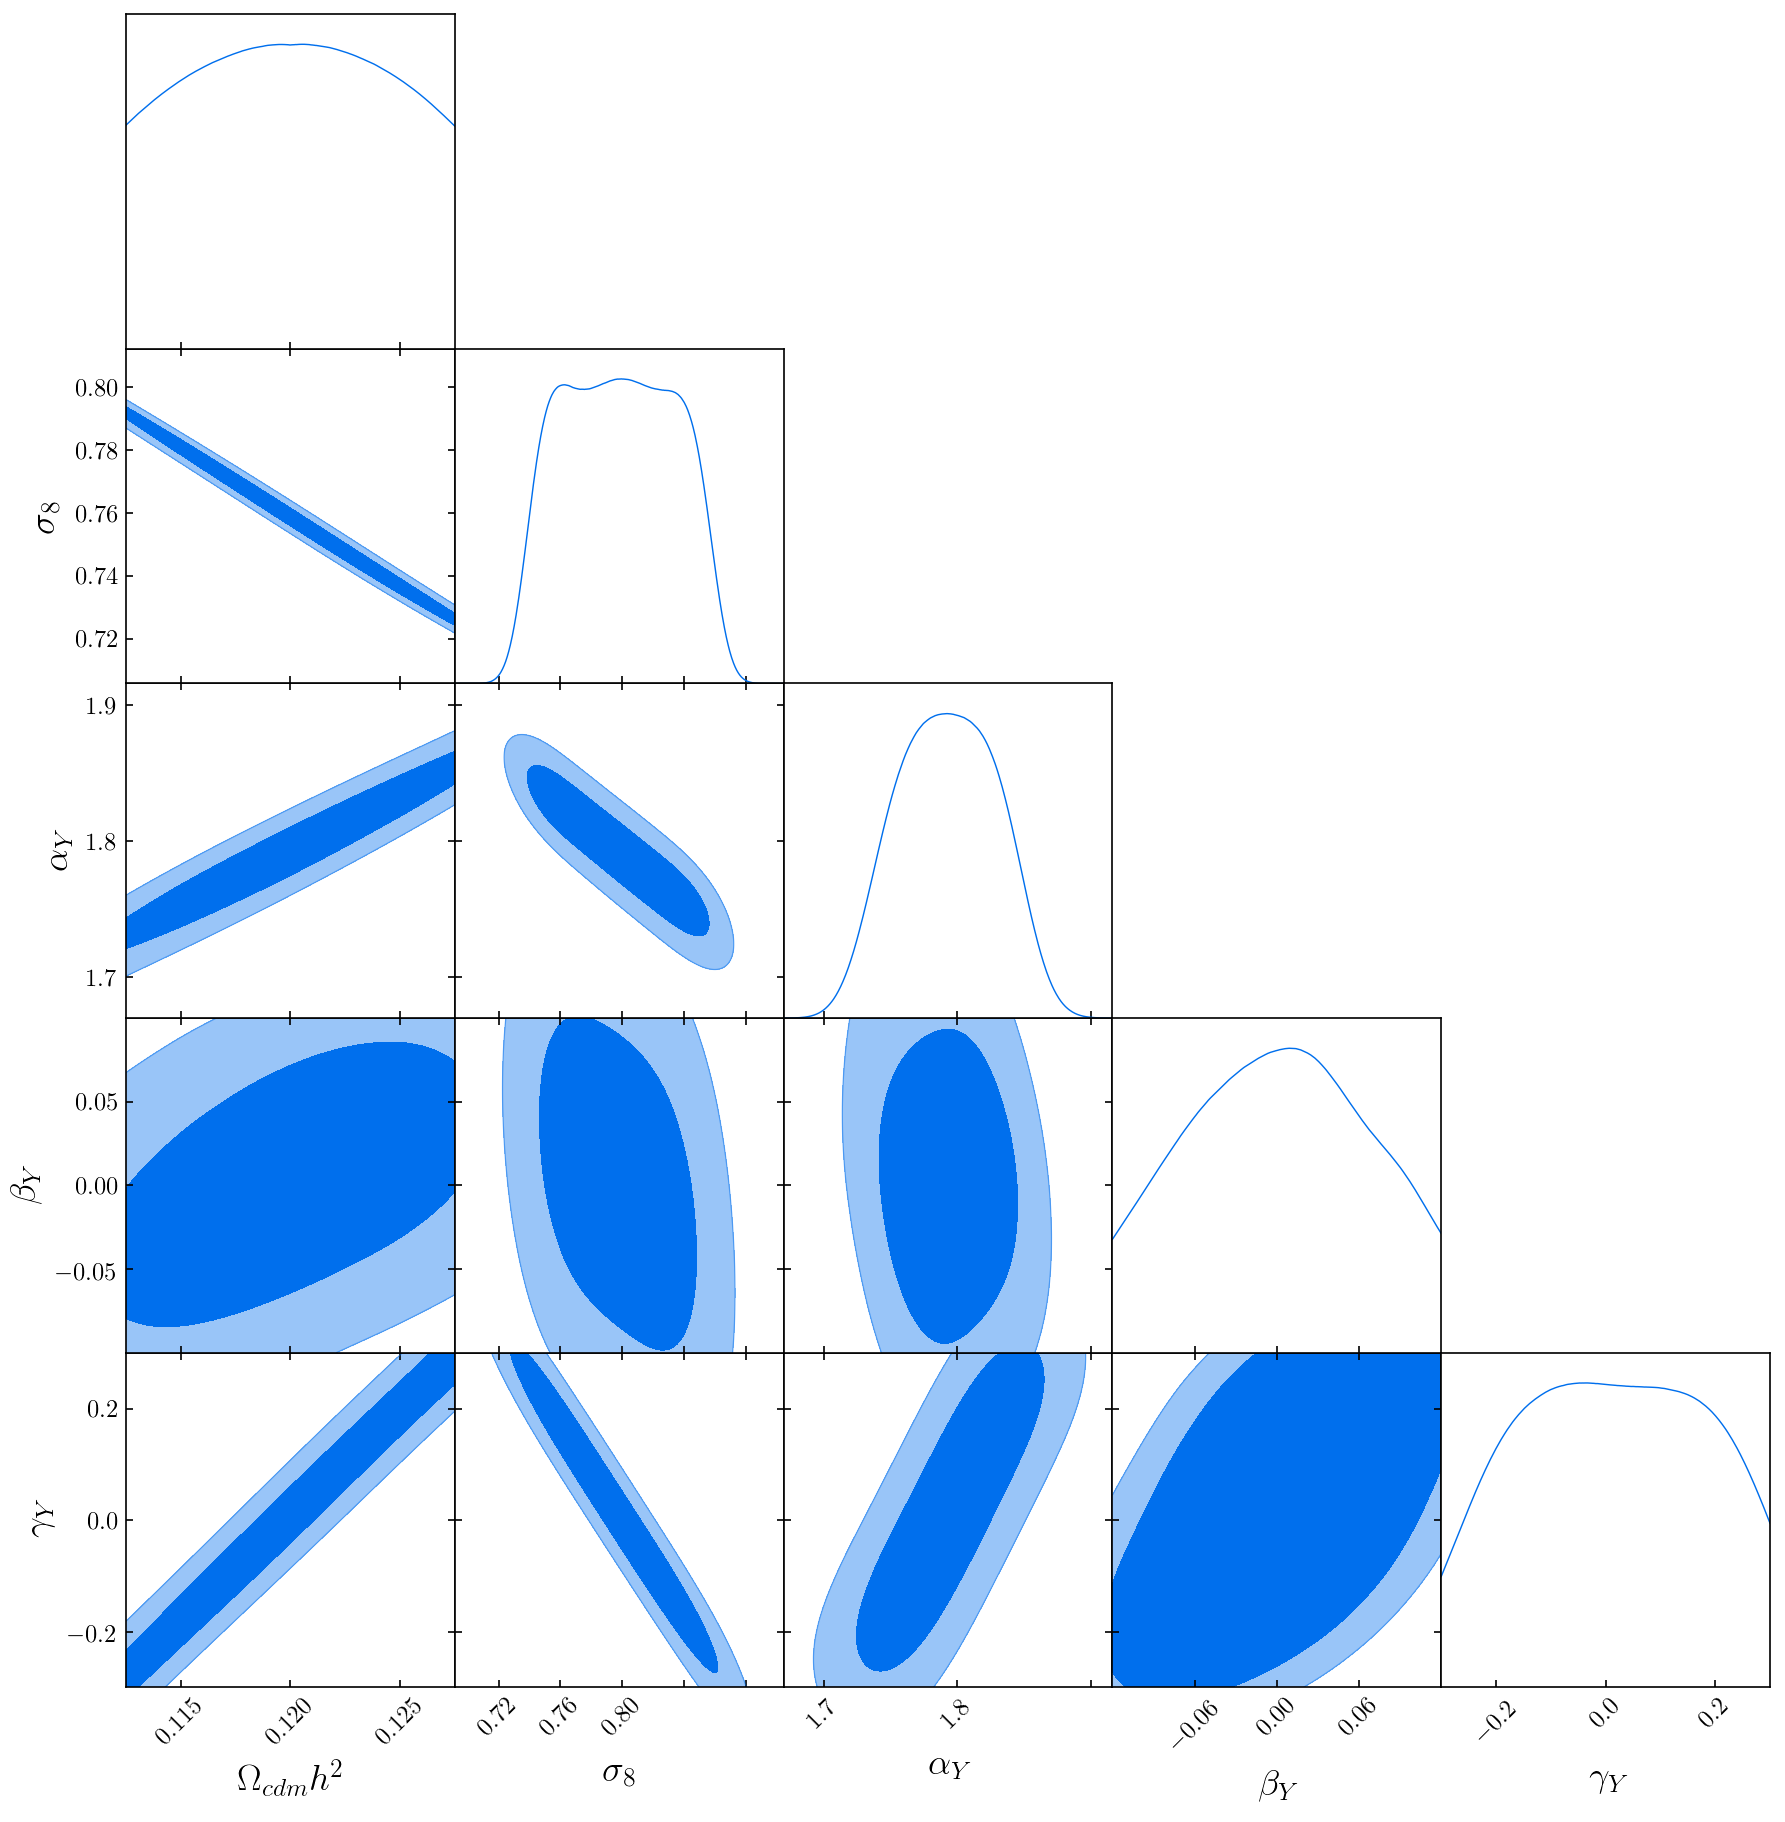

1204.834756315


In [36]:
t1 = time.process_time()
DelfiEnsemble.fisher_pretraining()
t2 = time.process_time()
print(t2-t1)

## Sequential Neural Likelihood

In [37]:
n_initial = 100 
n_batch = 100 
n_populations = 10

/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 3.9824584149998827
simulation time: 3.965311034000024
simulation time: 3.9453822950001722
simulation time: 3.9402963800000634
simulation time: 3.959953904000031
simulation time: 3.9669235459998617
simulation time: 3.9555174950000946
simulation time: 3.9583264339999005
simulation time: 3.959091400000034
simulation time: 3.959390552000059
simulation time: 3.9542007459999695
simulation time: 3.993411285000093
simulation time: 3.962329273000023
simulation time: 3.952487972000199
simulation time: 3.963736153000127
simulation time: 3.9485895110001366
simulation time: 3.954461519000006
simulation time: 3.959462806999909
simulation time: 3.985817623999992
simulation time: 3.965886242000124
simulation time: 3.956090430999893
simulation time: 3.9600658229999226
simulation time: 3.96572809700001
simulation time: 3.9594986480001353
simulation time: 3.9832865900000343
simulation time: 3.9846427170000425
simulation time: 3.963642669000137
simulation time: 3.9561155909998433
simulati

Sampling approximate posterior...
Done.
Removed no burn in


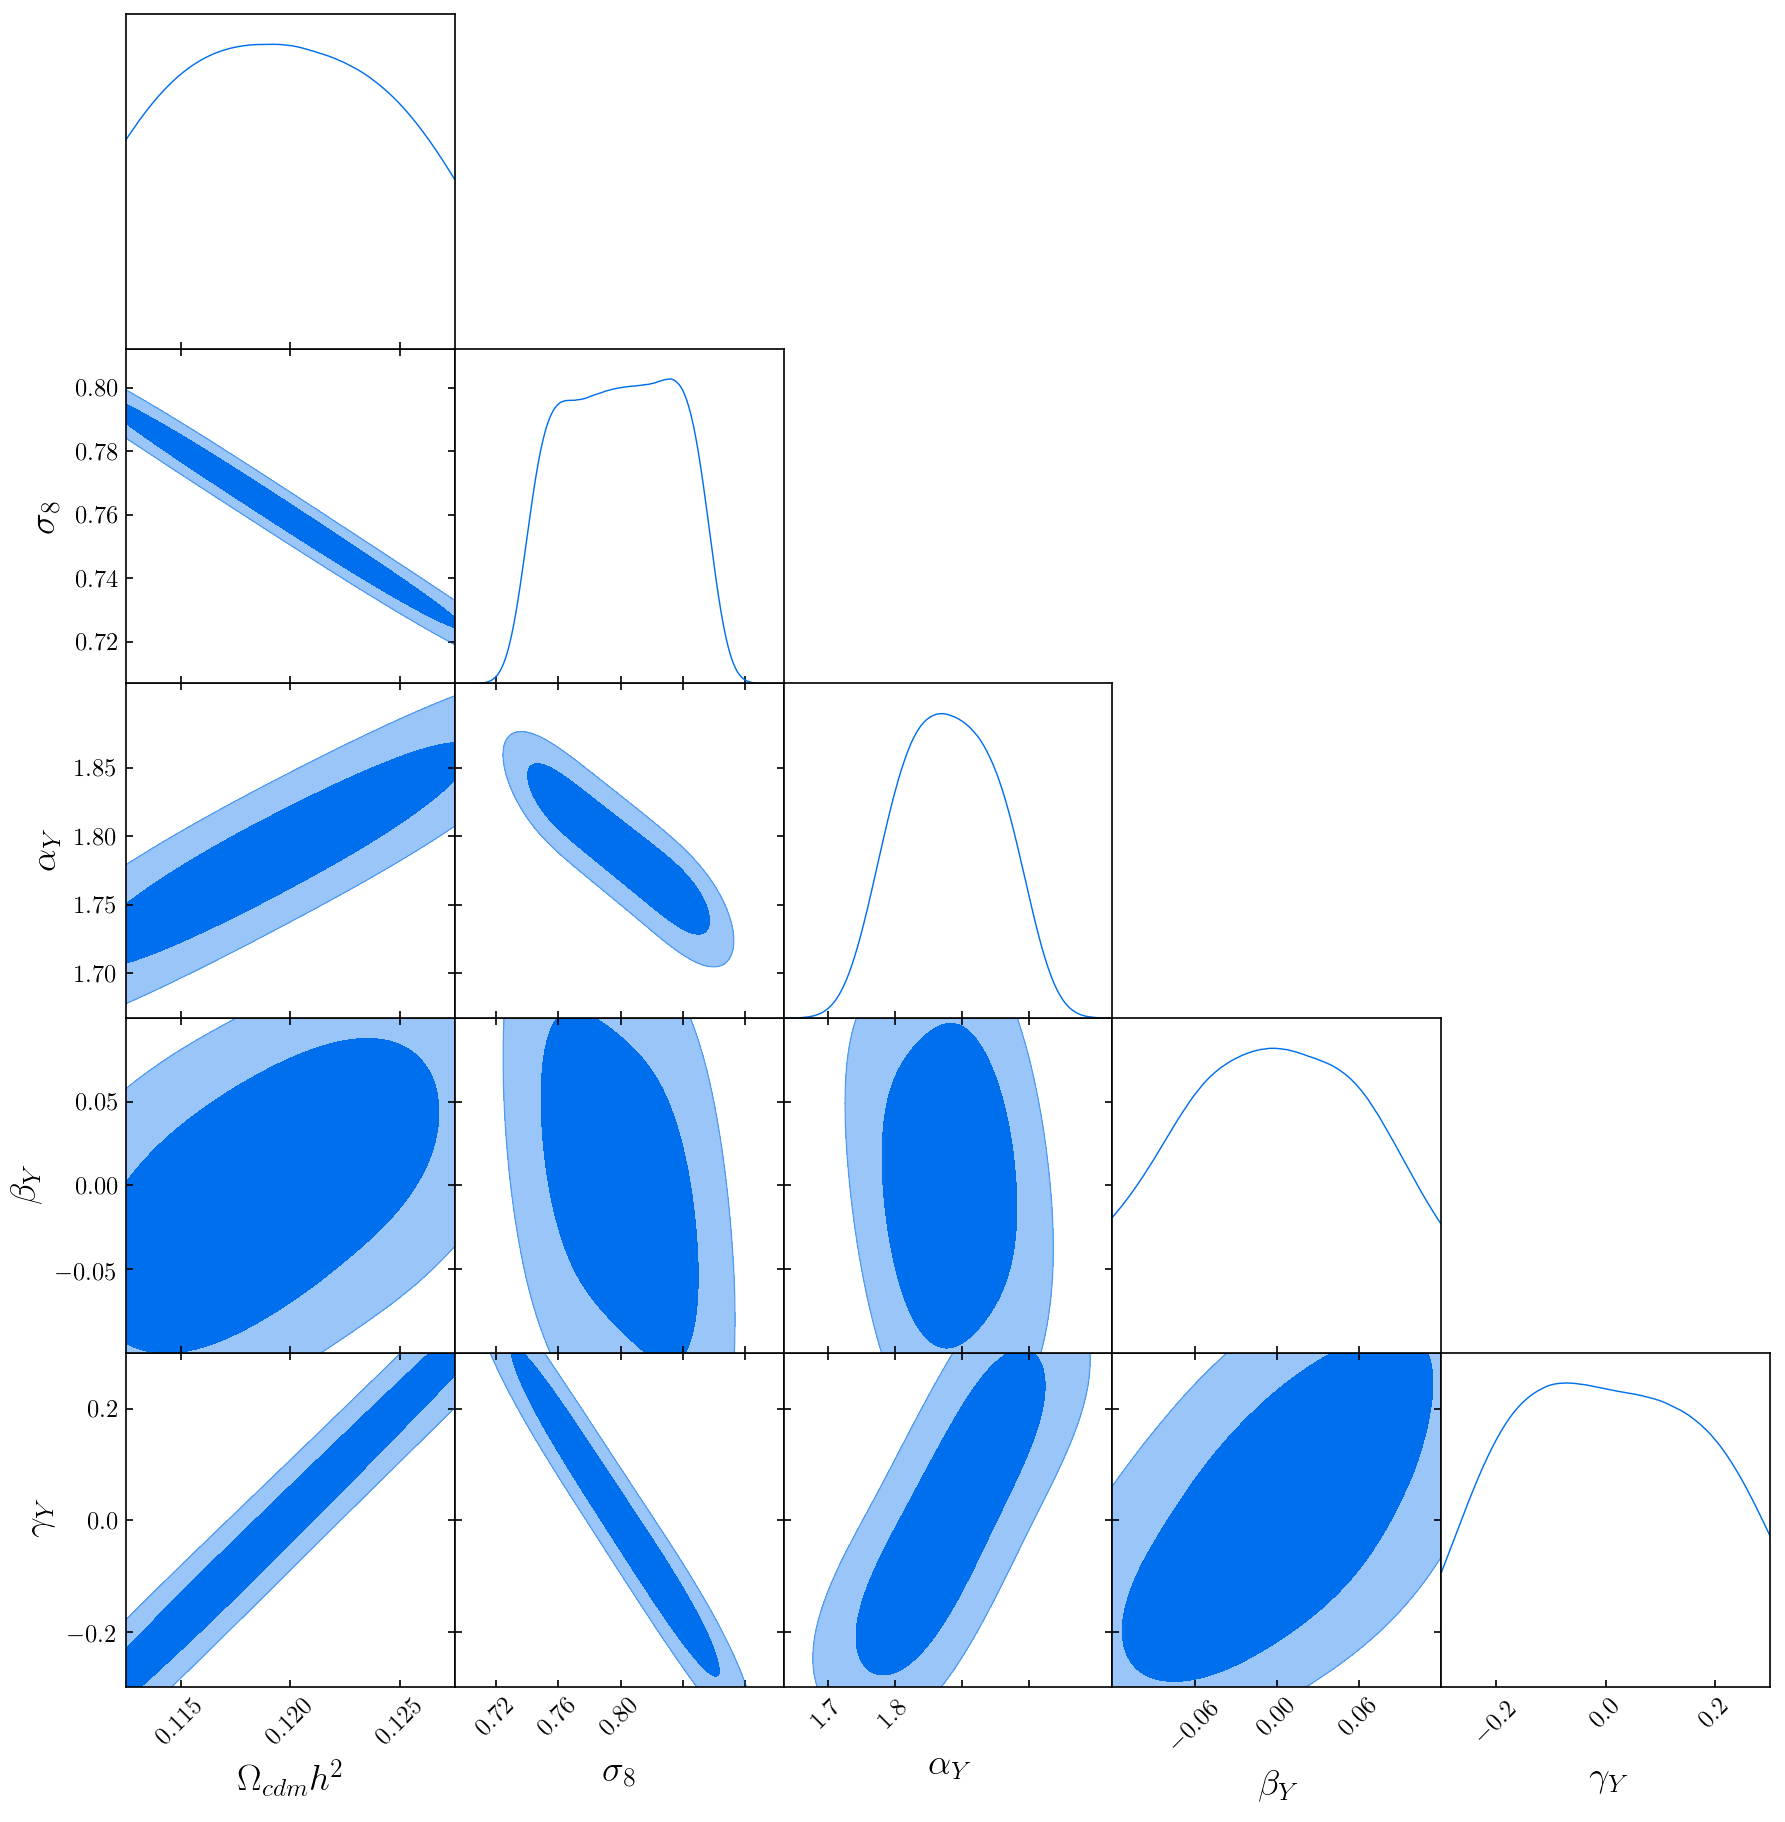

Population 1/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 3.9725185800000418
simulation time: 3.958783972999754
simulation time: 4.009133642999586
simulation time: 3.9612088209996728
simulation time: 3.9532947190000414
simulation time: 3.9584707640001398
simulation time: 3.952883194000151
simulation time: 3.956145362999905
simulation time: 3.9788961579997704
simulation time: 3.953139538999949
simulation time: 3.9512916089997816
simulation time: 3.961485641999843
simulation time: 3.948975684999823
simulation time: 3.9545373019996077
simulation time: 3.9595052079998823
simulation time: 4.011369676999948
simulation time: 4.0181909490002
simulation time: 4.067651783000201
simulation time: 4.017450254999858
simulation time: 4.01881020799965
simulation time: 4.020773761000328
simulation time: 4.026656293000087
simulation time: 4.039158067000244
simulation time: 4.135446581999986
simulation time: 4.0195687030000045
simulation time: 4.032517785999971
simulation time: 4.056834041000002
simulation time: 4.034190886000033
simulation tim

Sampling approximate posterior...
Done.
Removed no burn in


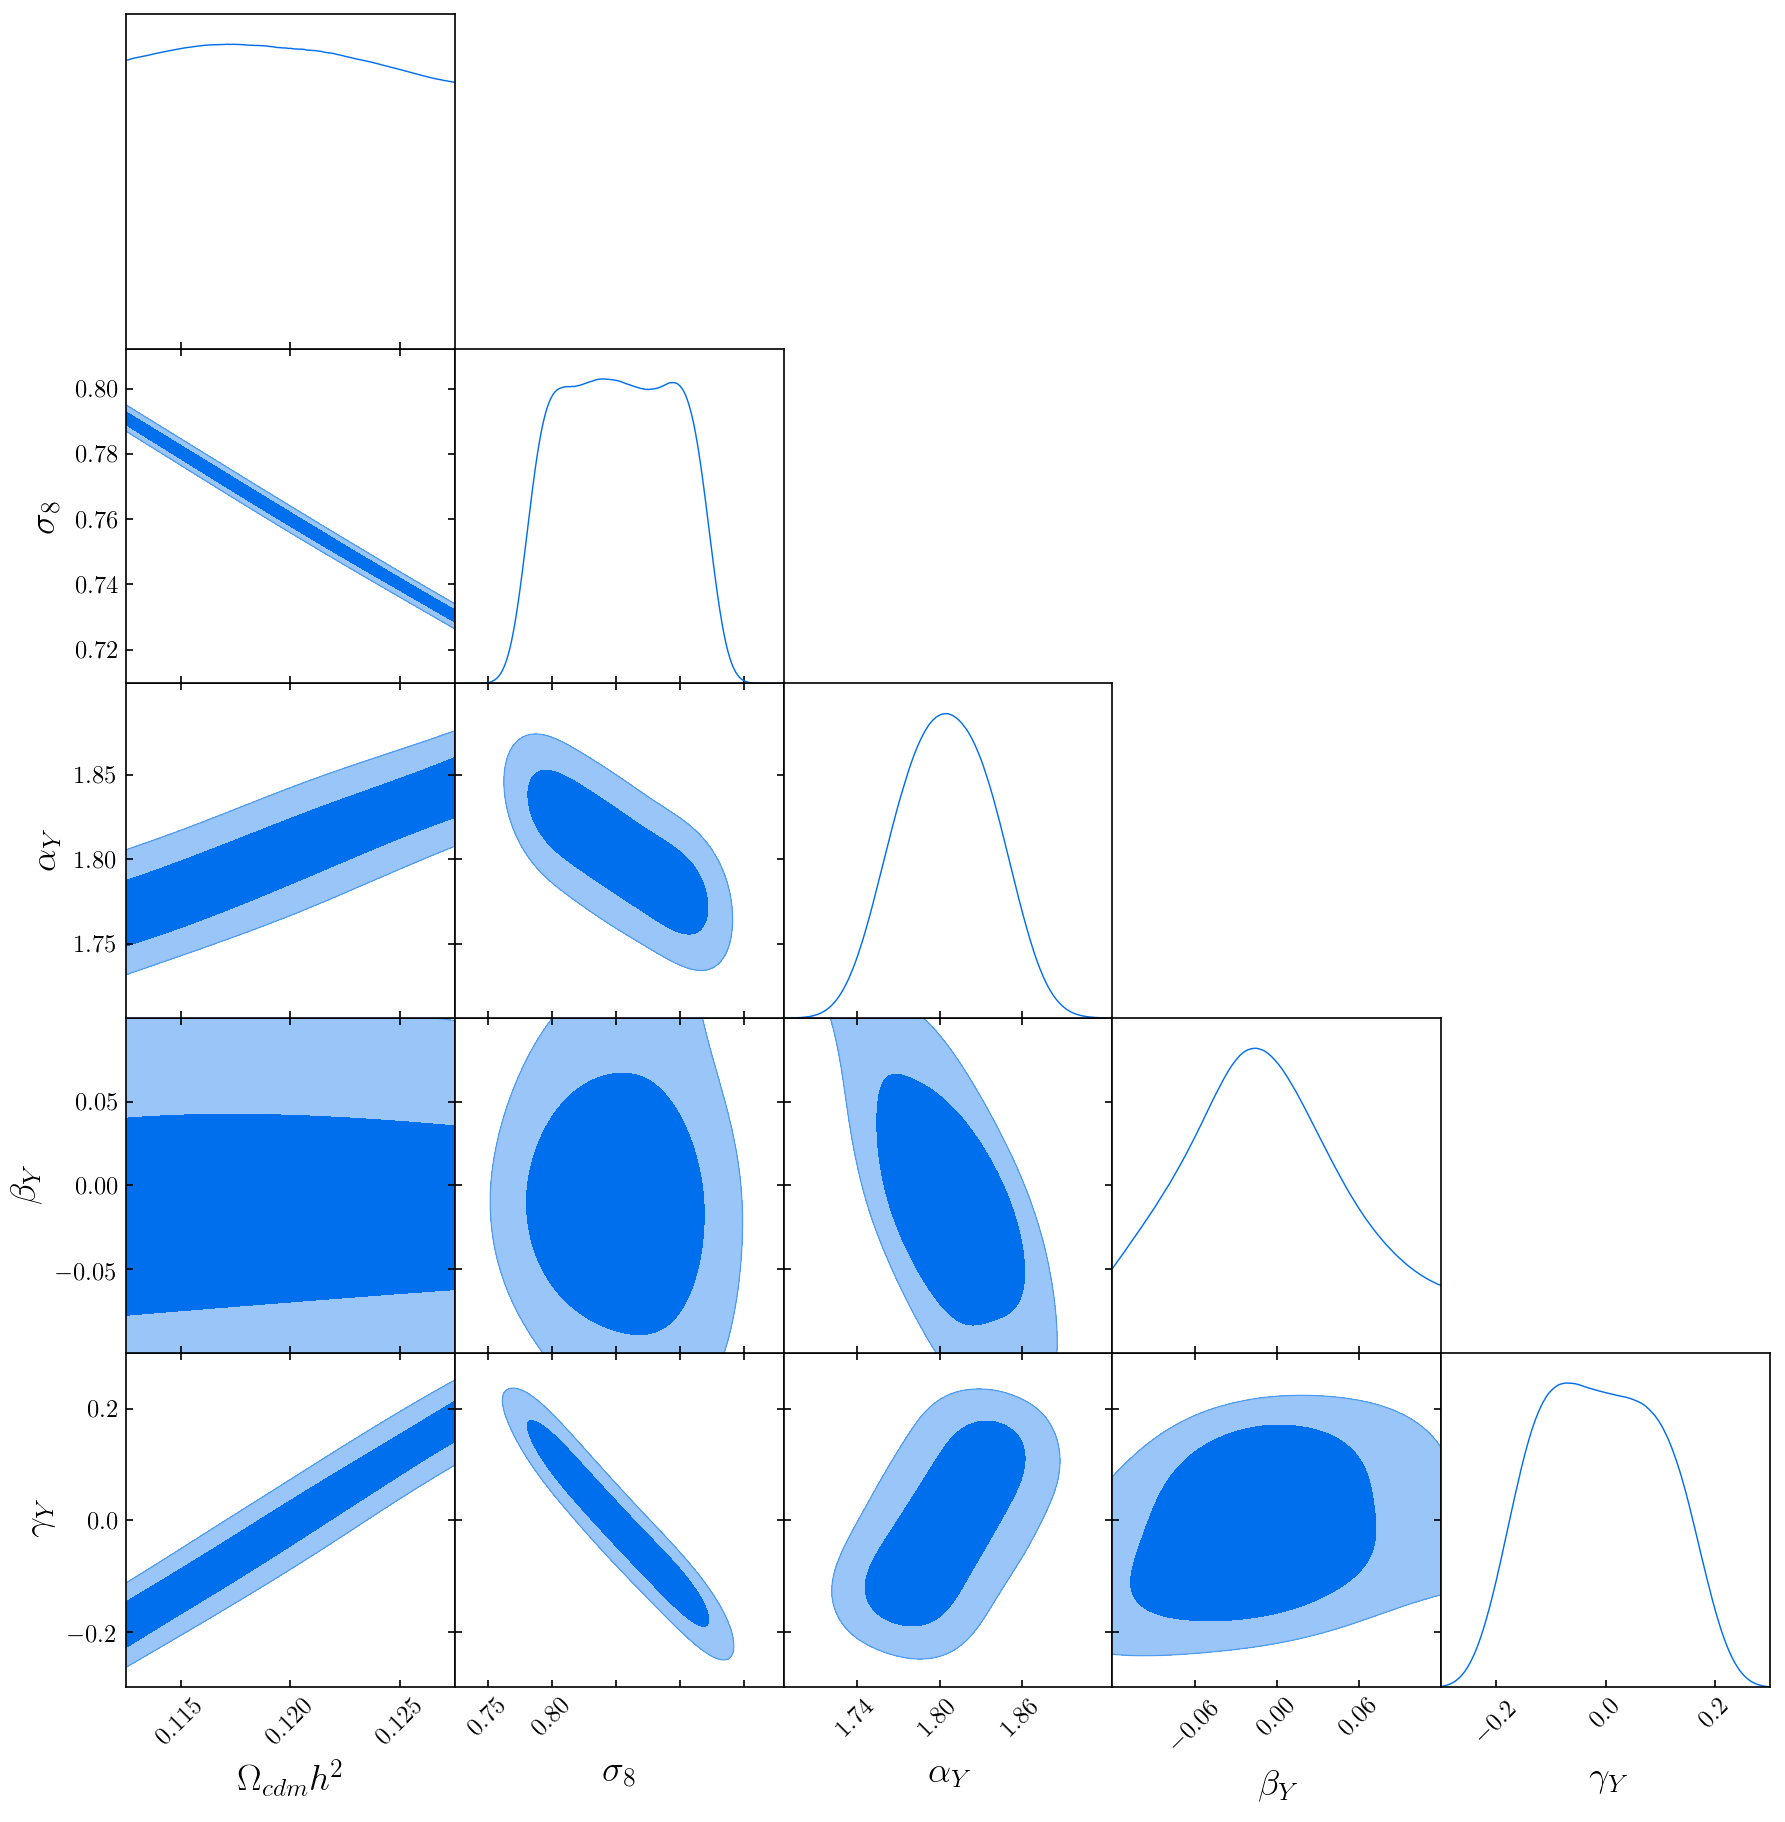

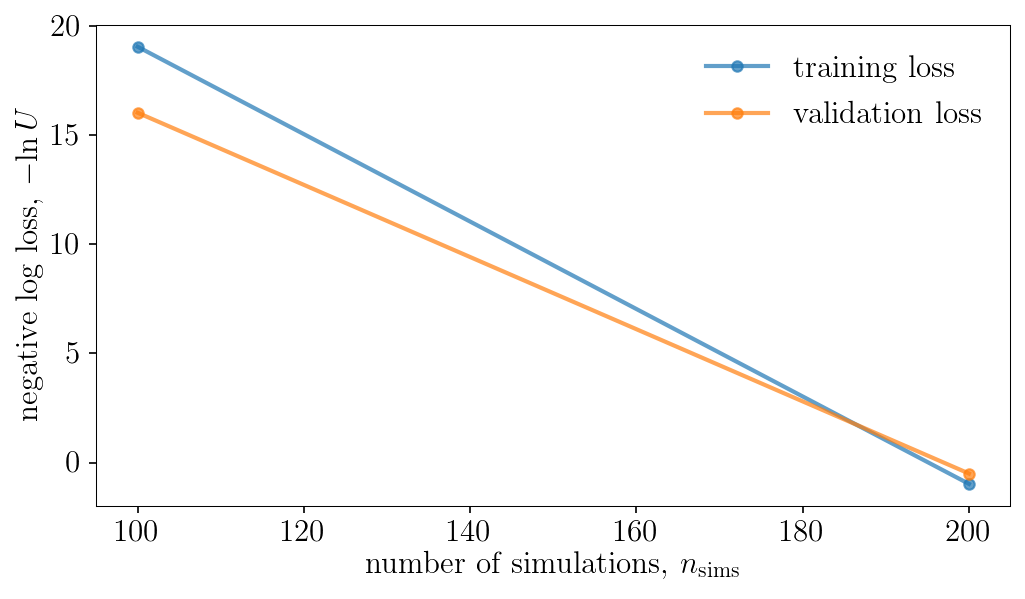

Population 2/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.130929490000199
simulation time: 3.9962383020001653
simulation time: 3.998740593000093
simulation time: 3.991096582999944
simulation time: 4.009540908999952
simulation time: 4.003127743999812
simulation time: 4.0360495370000535
simulation time: 4.002890857999773
simulation time: 3.999419499000396
simulation time: 3.996932311999899
simulation time: 3.9997334340000634
simulation time: 3.9951398589996643
simulation time: 4.010988513000029
simulation time: 4.017596987999696
simulation time: 4.020082035000087
simulation time: 3.9996616540001924
simulation time: 4.000803461999567
simulation time: 4.0033658209999885
simulation time: 4.005630323999867
simulation time: 4.058468490999985
simulation time: 4.0058952399999725
simulation time: 3.9967965630003164
simulation time: 4.0403676360001555
simulation time: 4.004701811999894
simulation time: 4.033018414000253
simulation time: 4.001634518999708
simulation time: 4.041651340000044
simulation time: 4.044446942999912
simulation 

Sampling approximate posterior...
Done.
Removed no burn in


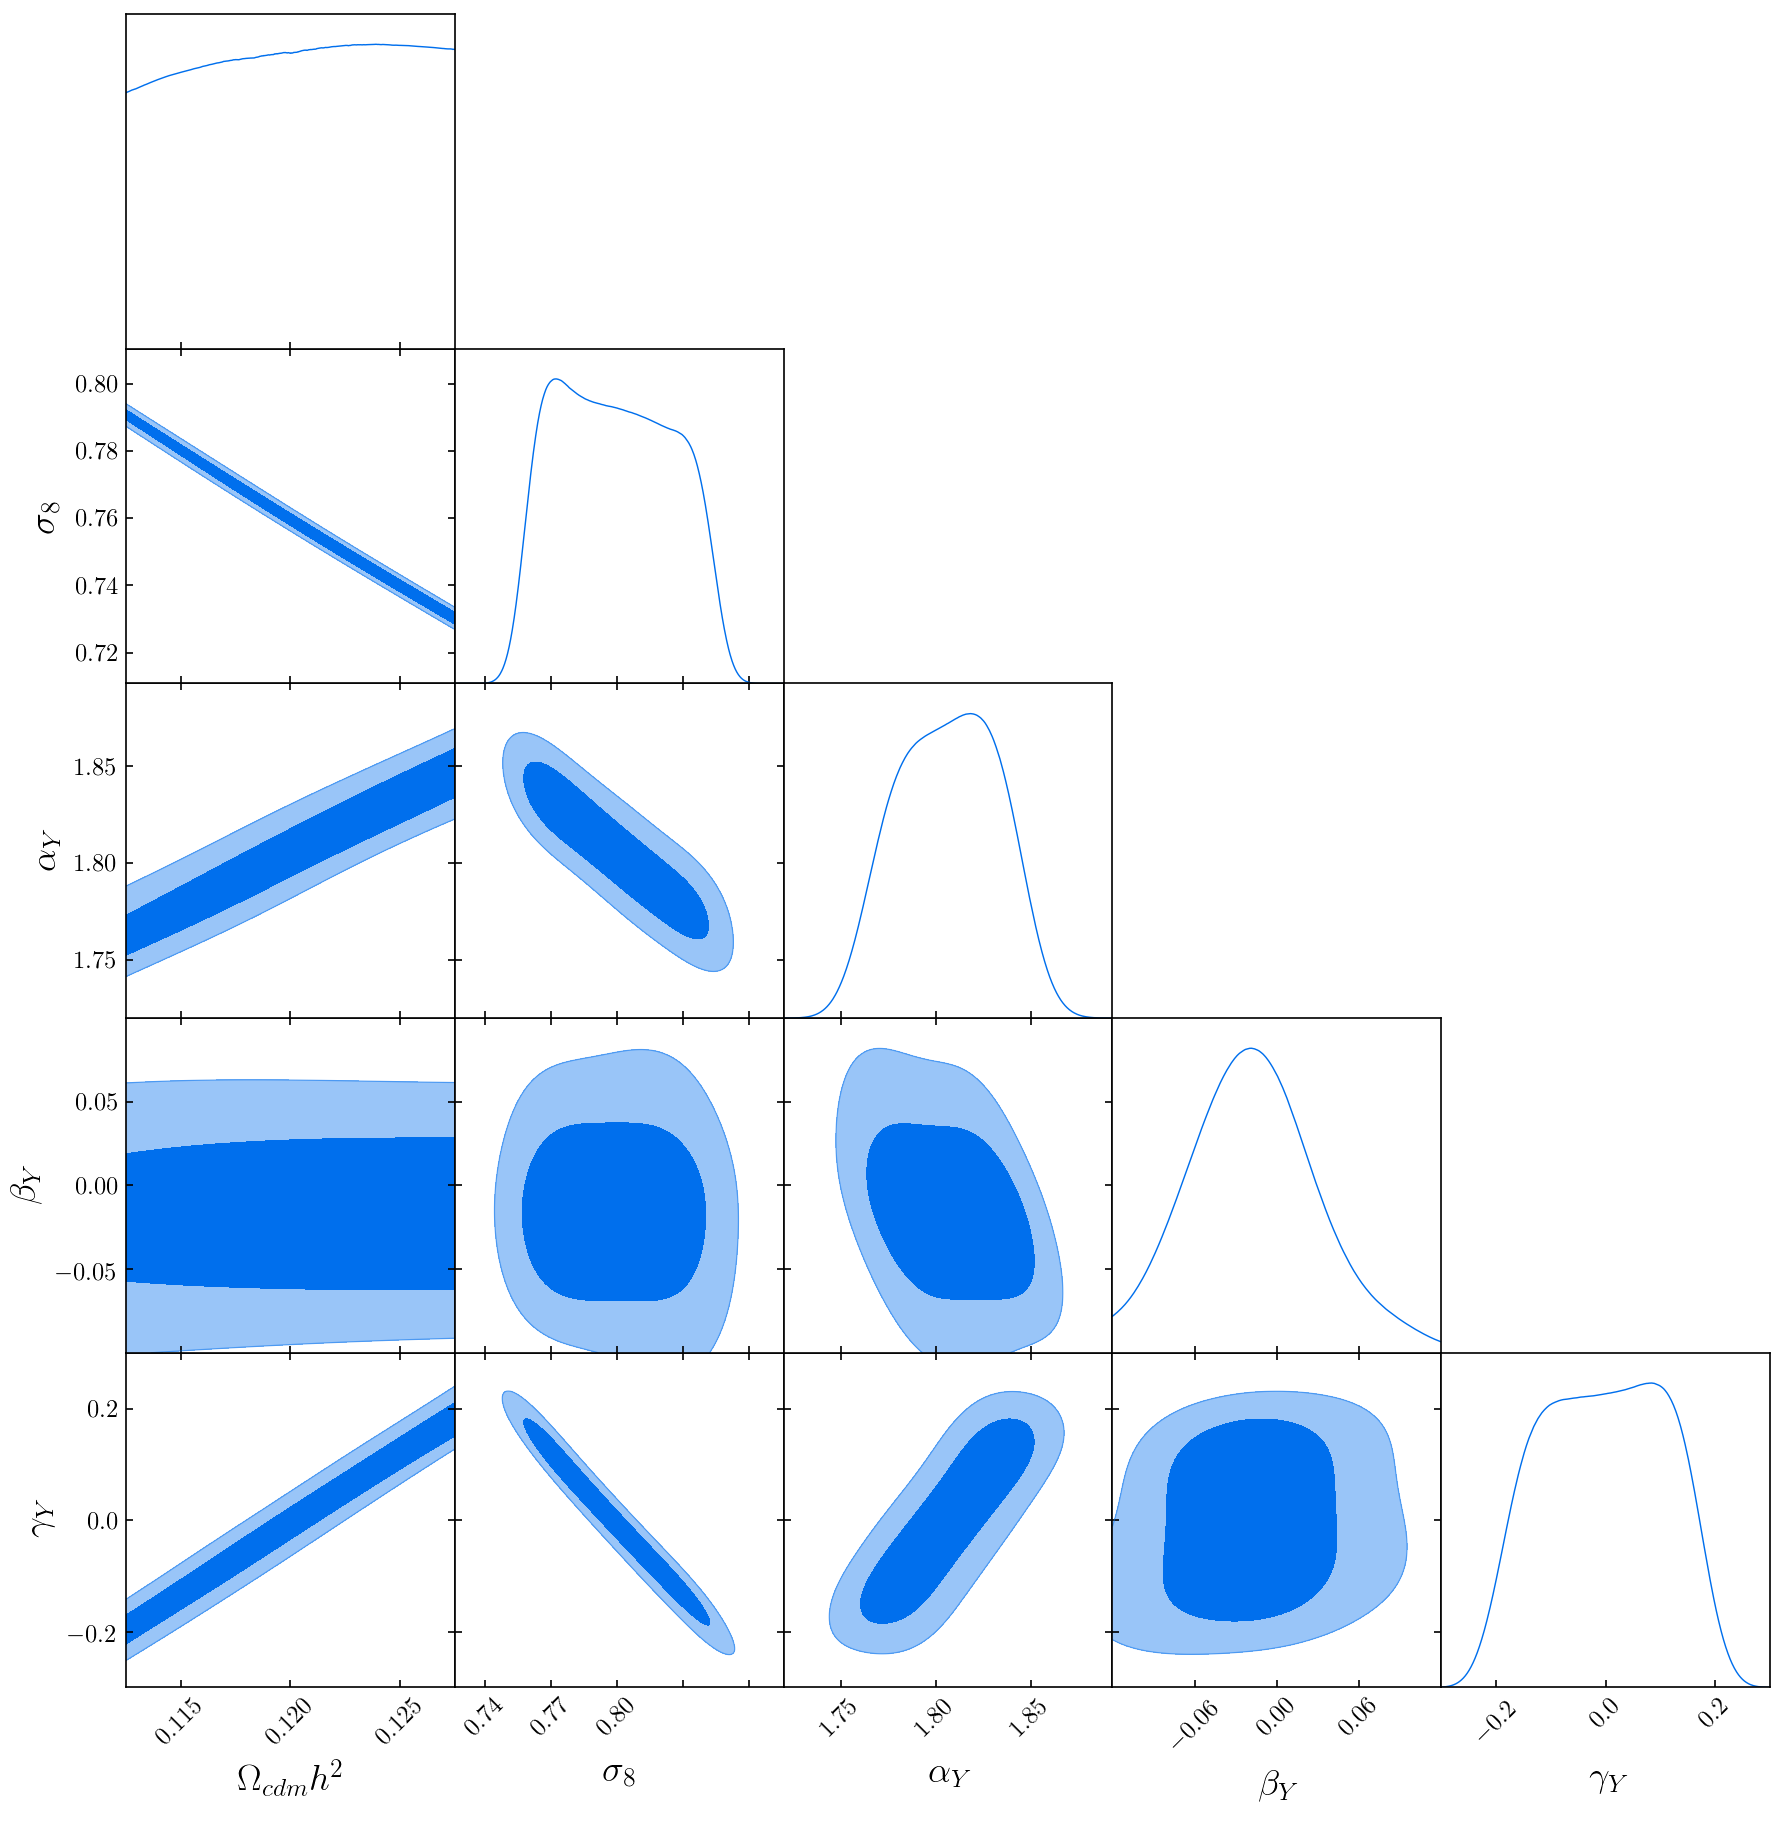

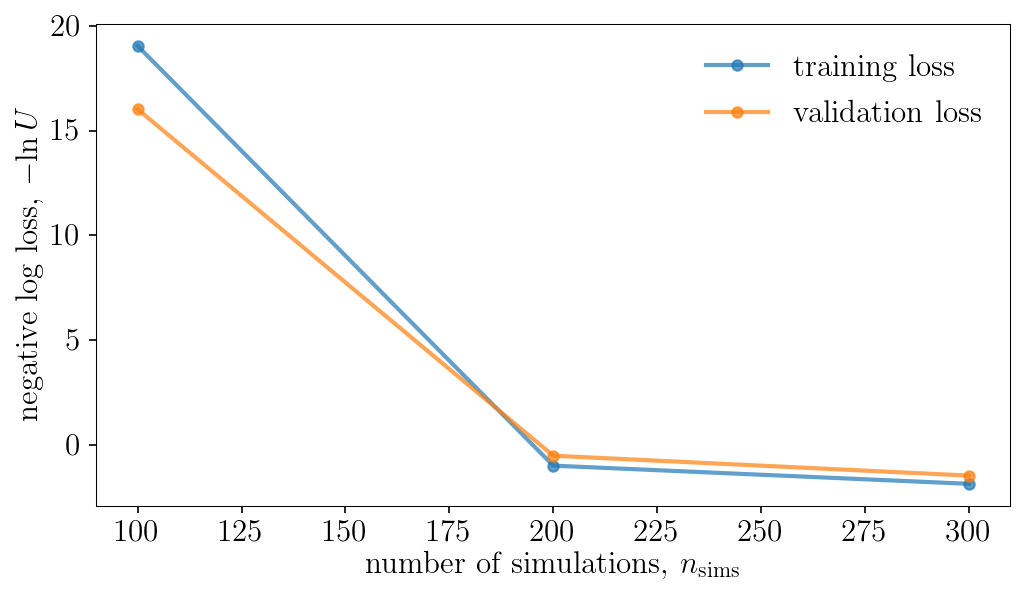

Population 3/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.217804560999866
simulation time: 4.010421563999898
simulation time: 4.027718664000076
simulation time: 4.01016998499972
simulation time: 4.034157063999828
simulation time: 4.027577793000091
simulation time: 4.039261515999897
simulation time: 4.023049619999711
simulation time: 4.020990708000227
simulation time: 4.027623285000118
simulation time: 4.0247040659996856
simulation time: 4.016538461999971
simulation time: 4.06574641799989
simulation time: 4.019978325000011
simulation time: 4.018002574000093
simulation time: 4.014901001999988
simulation time: 4.030378070999632
simulation time: 4.032302714000252
simulation time: 4.031869219999862
simulation time: 4.058507252000254
simulation time: 4.019828512000004
simulation time: 4.022783724999954
simulation time: 4.0595255230000475
simulation time: 4.030726054999832
simulation time: 4.029131999000128
simulation time: 4.048124898000424
simulation time: 4.028294301999267
simulation time: 4.064269882999724
simulation time: 4.0

Sampling approximate posterior...
Done.
Removed no burn in


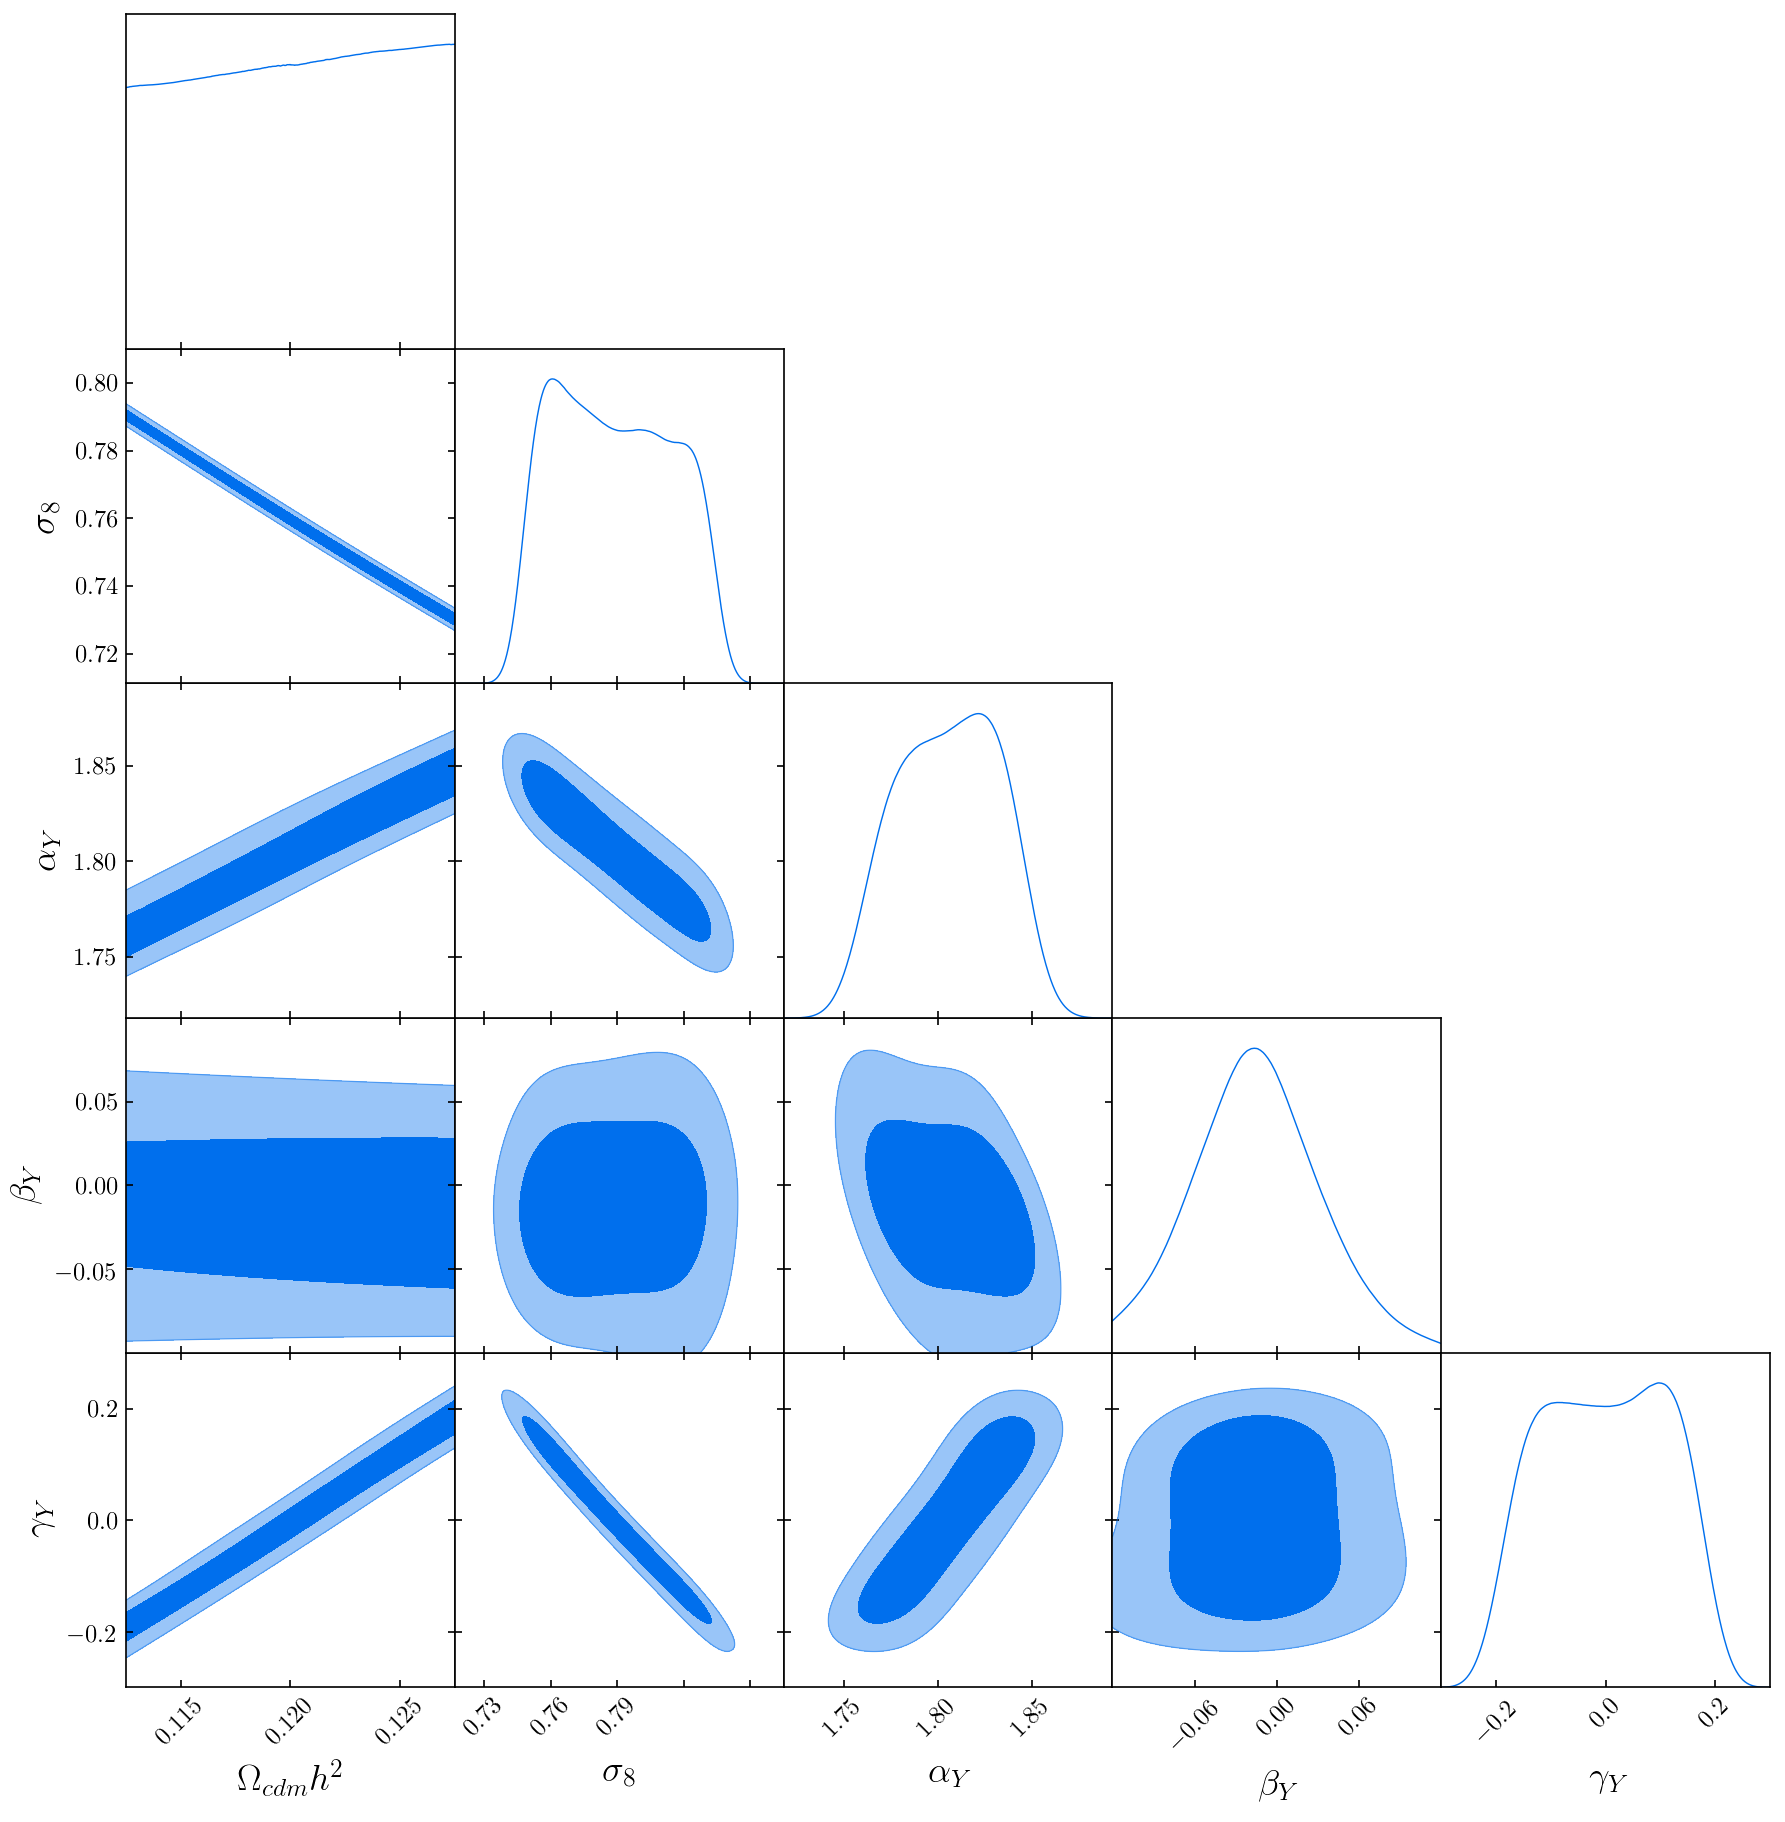

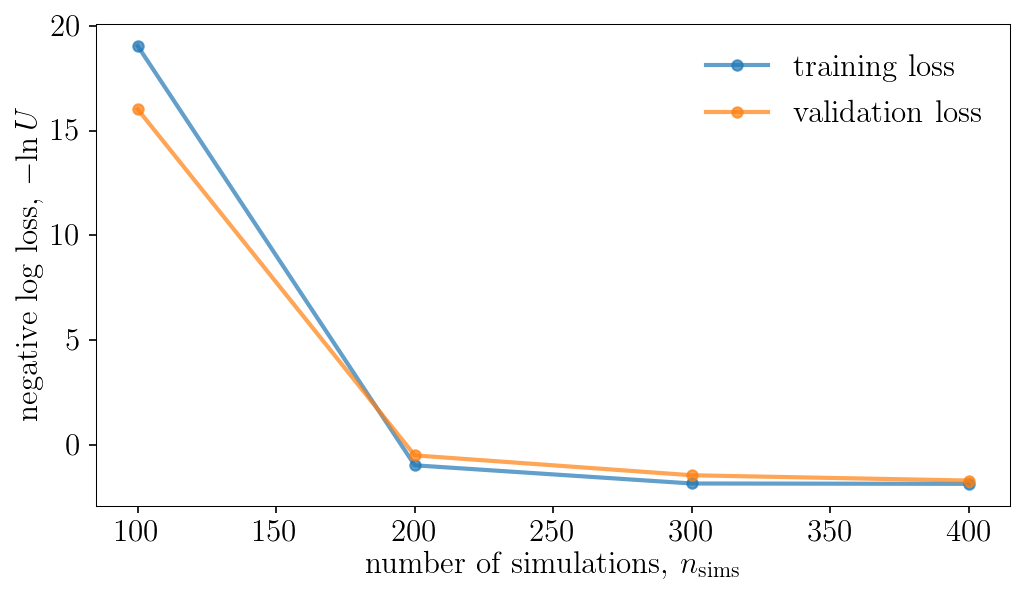

Population 4/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.096714618999613
simulation time: 4.0371265229996425
simulation time: 4.011040730999412
simulation time: 4.071314447000077
simulation time: 4.082778775999941
simulation time: 4.074575160999302
simulation time: 4.0754939640000885
simulation time: 4.079677241999889
simulation time: 4.031883435000054
simulation time: 4.078031611999904
simulation time: 4.084048237000388
simulation time: 4.063962251000703
simulation time: 4.0899490709998645
simulation time: 4.084405026999775
simulation time: 4.036302946999967
simulation time: 4.0103658449997965
simulation time: 4.008214988999498
simulation time: 4.007725140999355
simulation time: 4.002183804000197
simulation time: 4.007893832999798
simulation time: 4.018533575999754
simulation time: 4.0150512529999105
simulation time: 4.004025629000353
simulation time: 4.010855214000003
simulation time: 4.026153997999245
simulation time: 4.010101262999342
simulation time: 4.010045115000139
simulation time: 4.035826436000207
simulation time

Sampling approximate posterior...
Done.
Removed no burn in


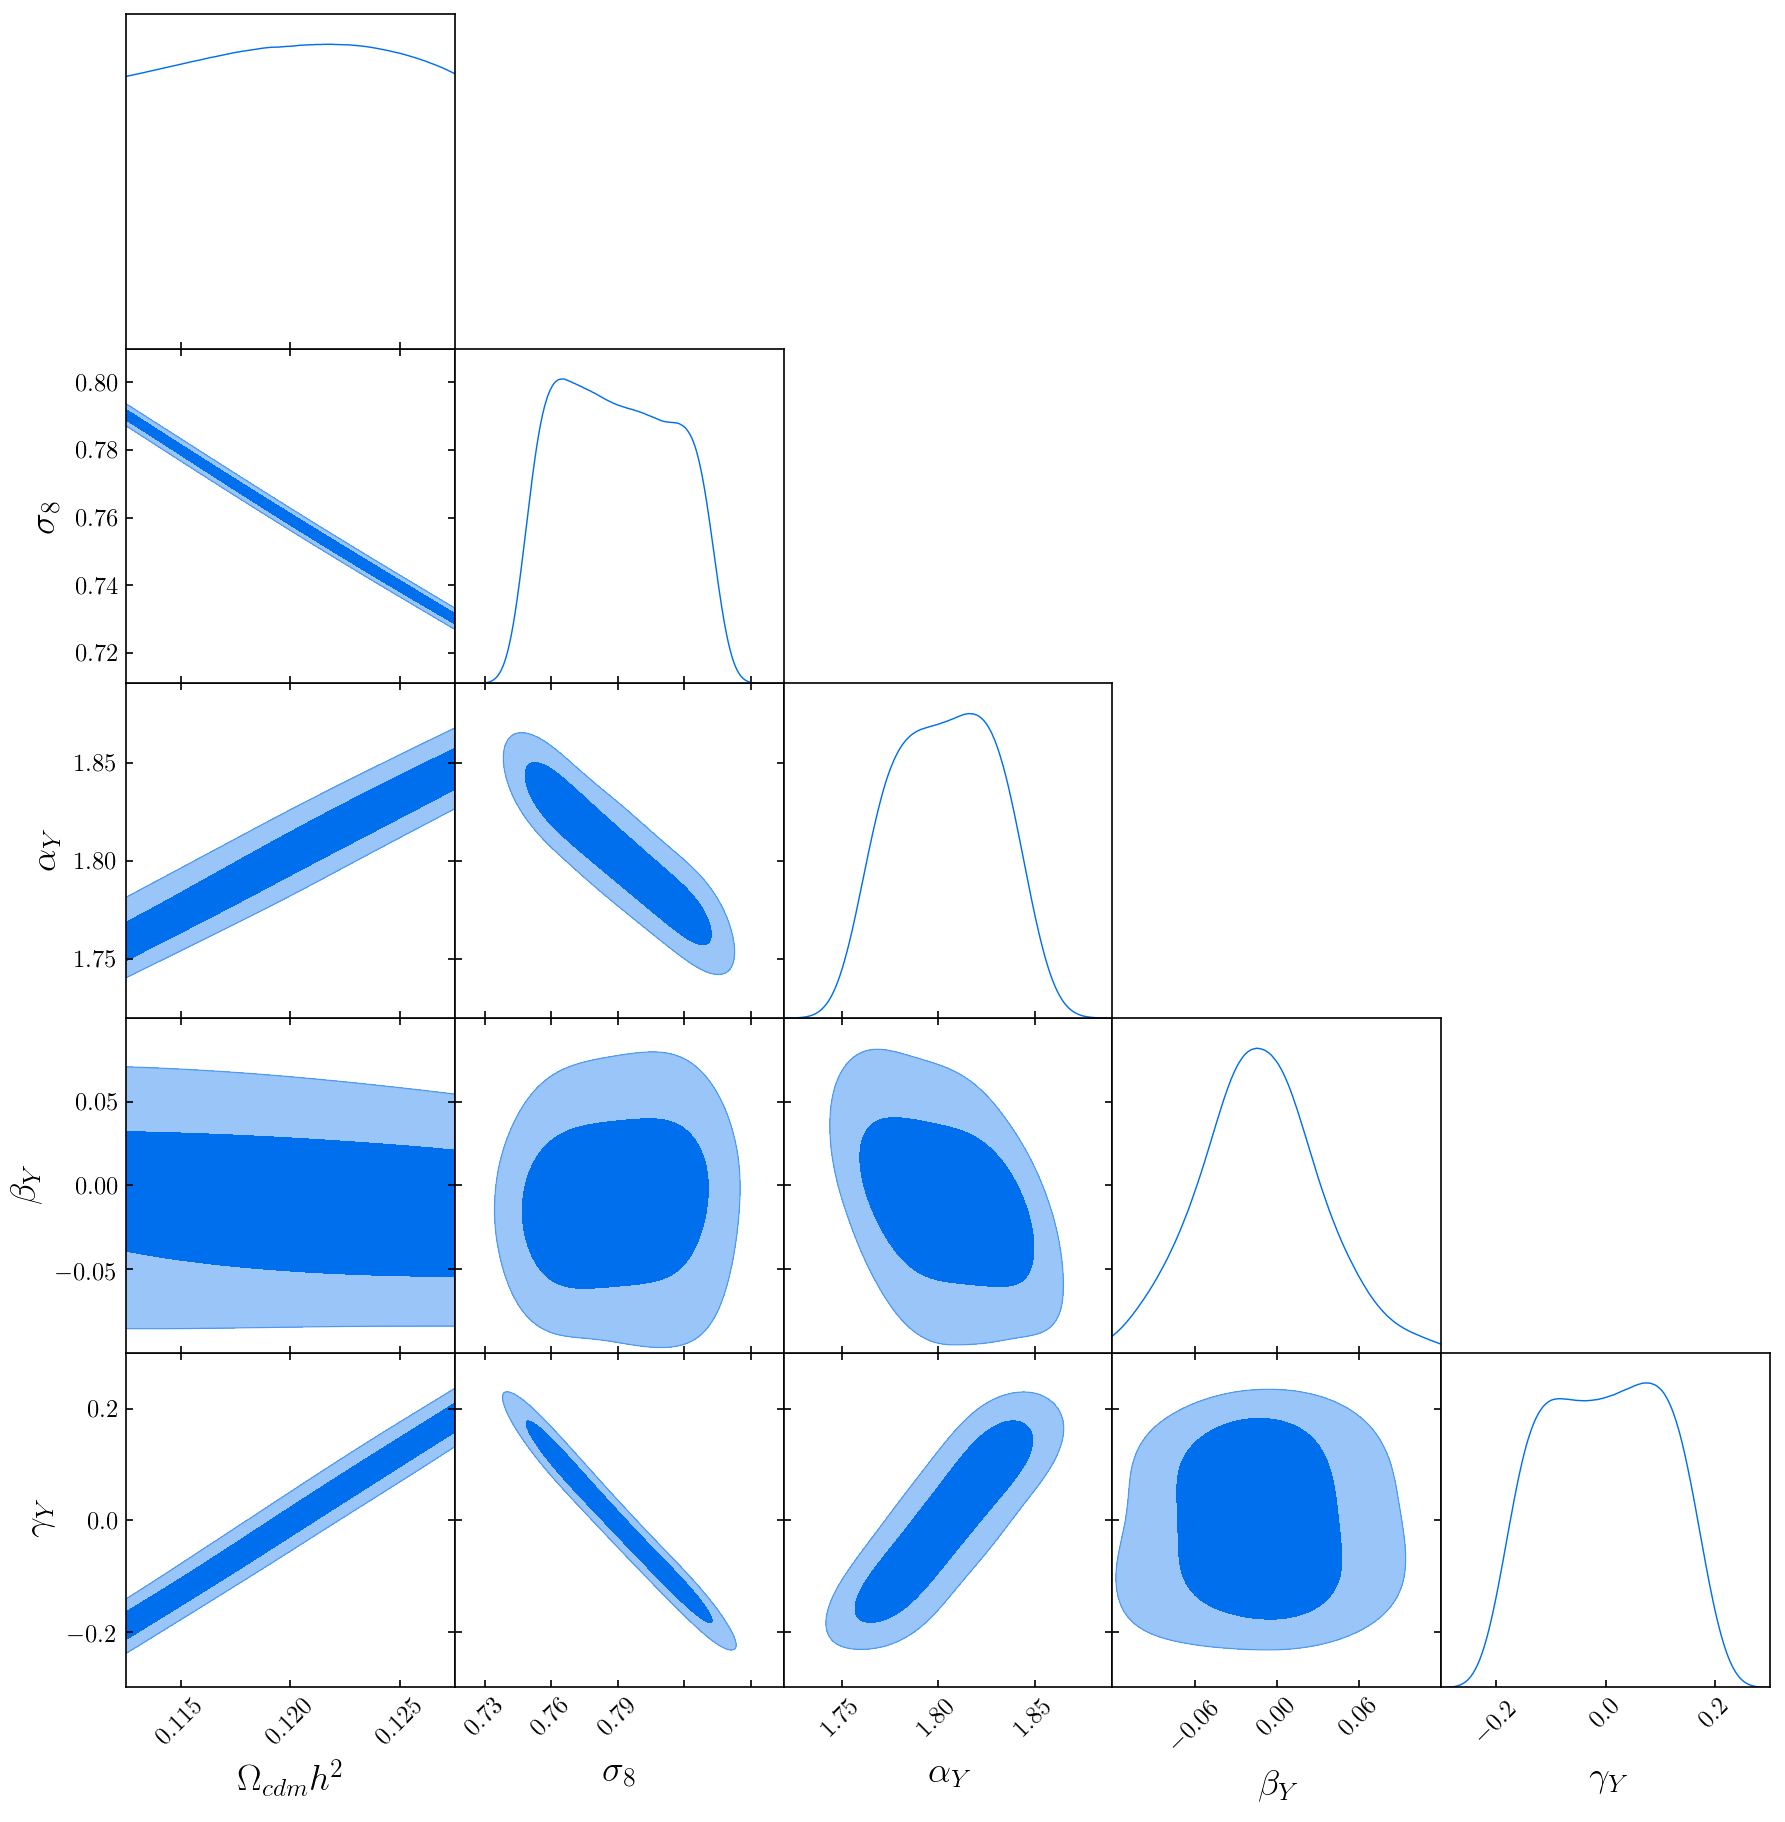

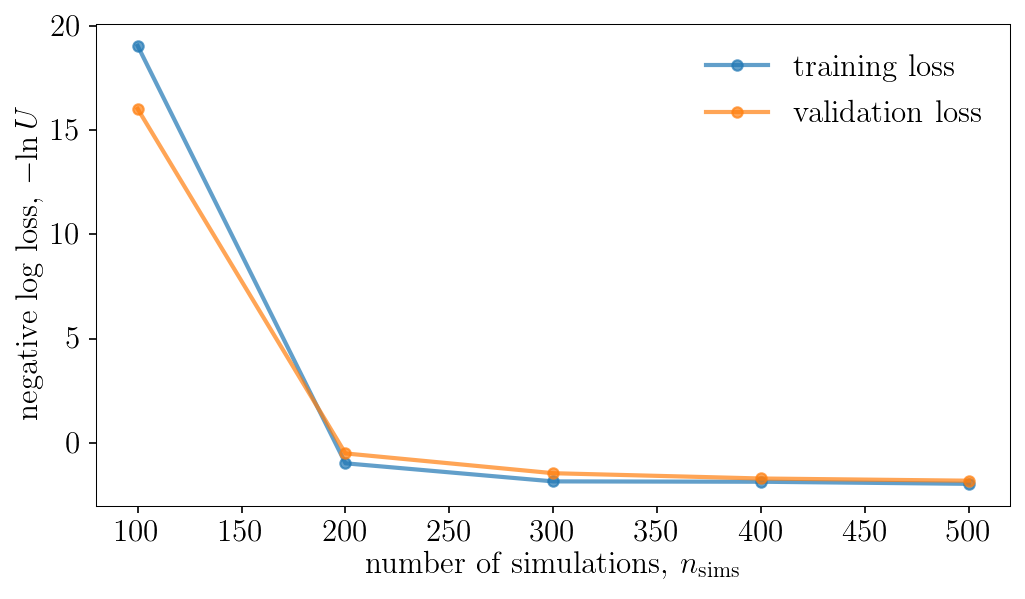

Population 5/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.106353594000211
simulation time: 4.01898251700004
simulation time: 4.022310390999337
simulation time: 4.027420393000284
simulation time: 4.052799919999416
simulation time: 4.021663081999577
simulation time: 4.022813077000137
simulation time: 4.046386117999646
simulation time: 4.12330621000001
simulation time: 4.02203800100051
simulation time: 4.035723314000279
simulation time: 4.0362661360004495
simulation time: 4.031150547999459
simulation time: 4.026664721999623
simulation time: 4.025041132000297
simulation time: 4.027922945000682
simulation time: 4.024583121999967
simulation time: 4.059159126999475
simulation time: 4.027893281000615
simulation time: 4.034054091000144
simulation time: 4.0814198719999695
simulation time: 4.022590764000597
simulation time: 4.021644913000273
simulation time: 4.037504864000766
simulation time: 4.042379944000459
simulation time: 4.030569604000448
simulation time: 4.082055270999263
simulation time: 4.090705209999214
simulation time: 4.06

Sampling approximate posterior...


Done.
Removed no burn in


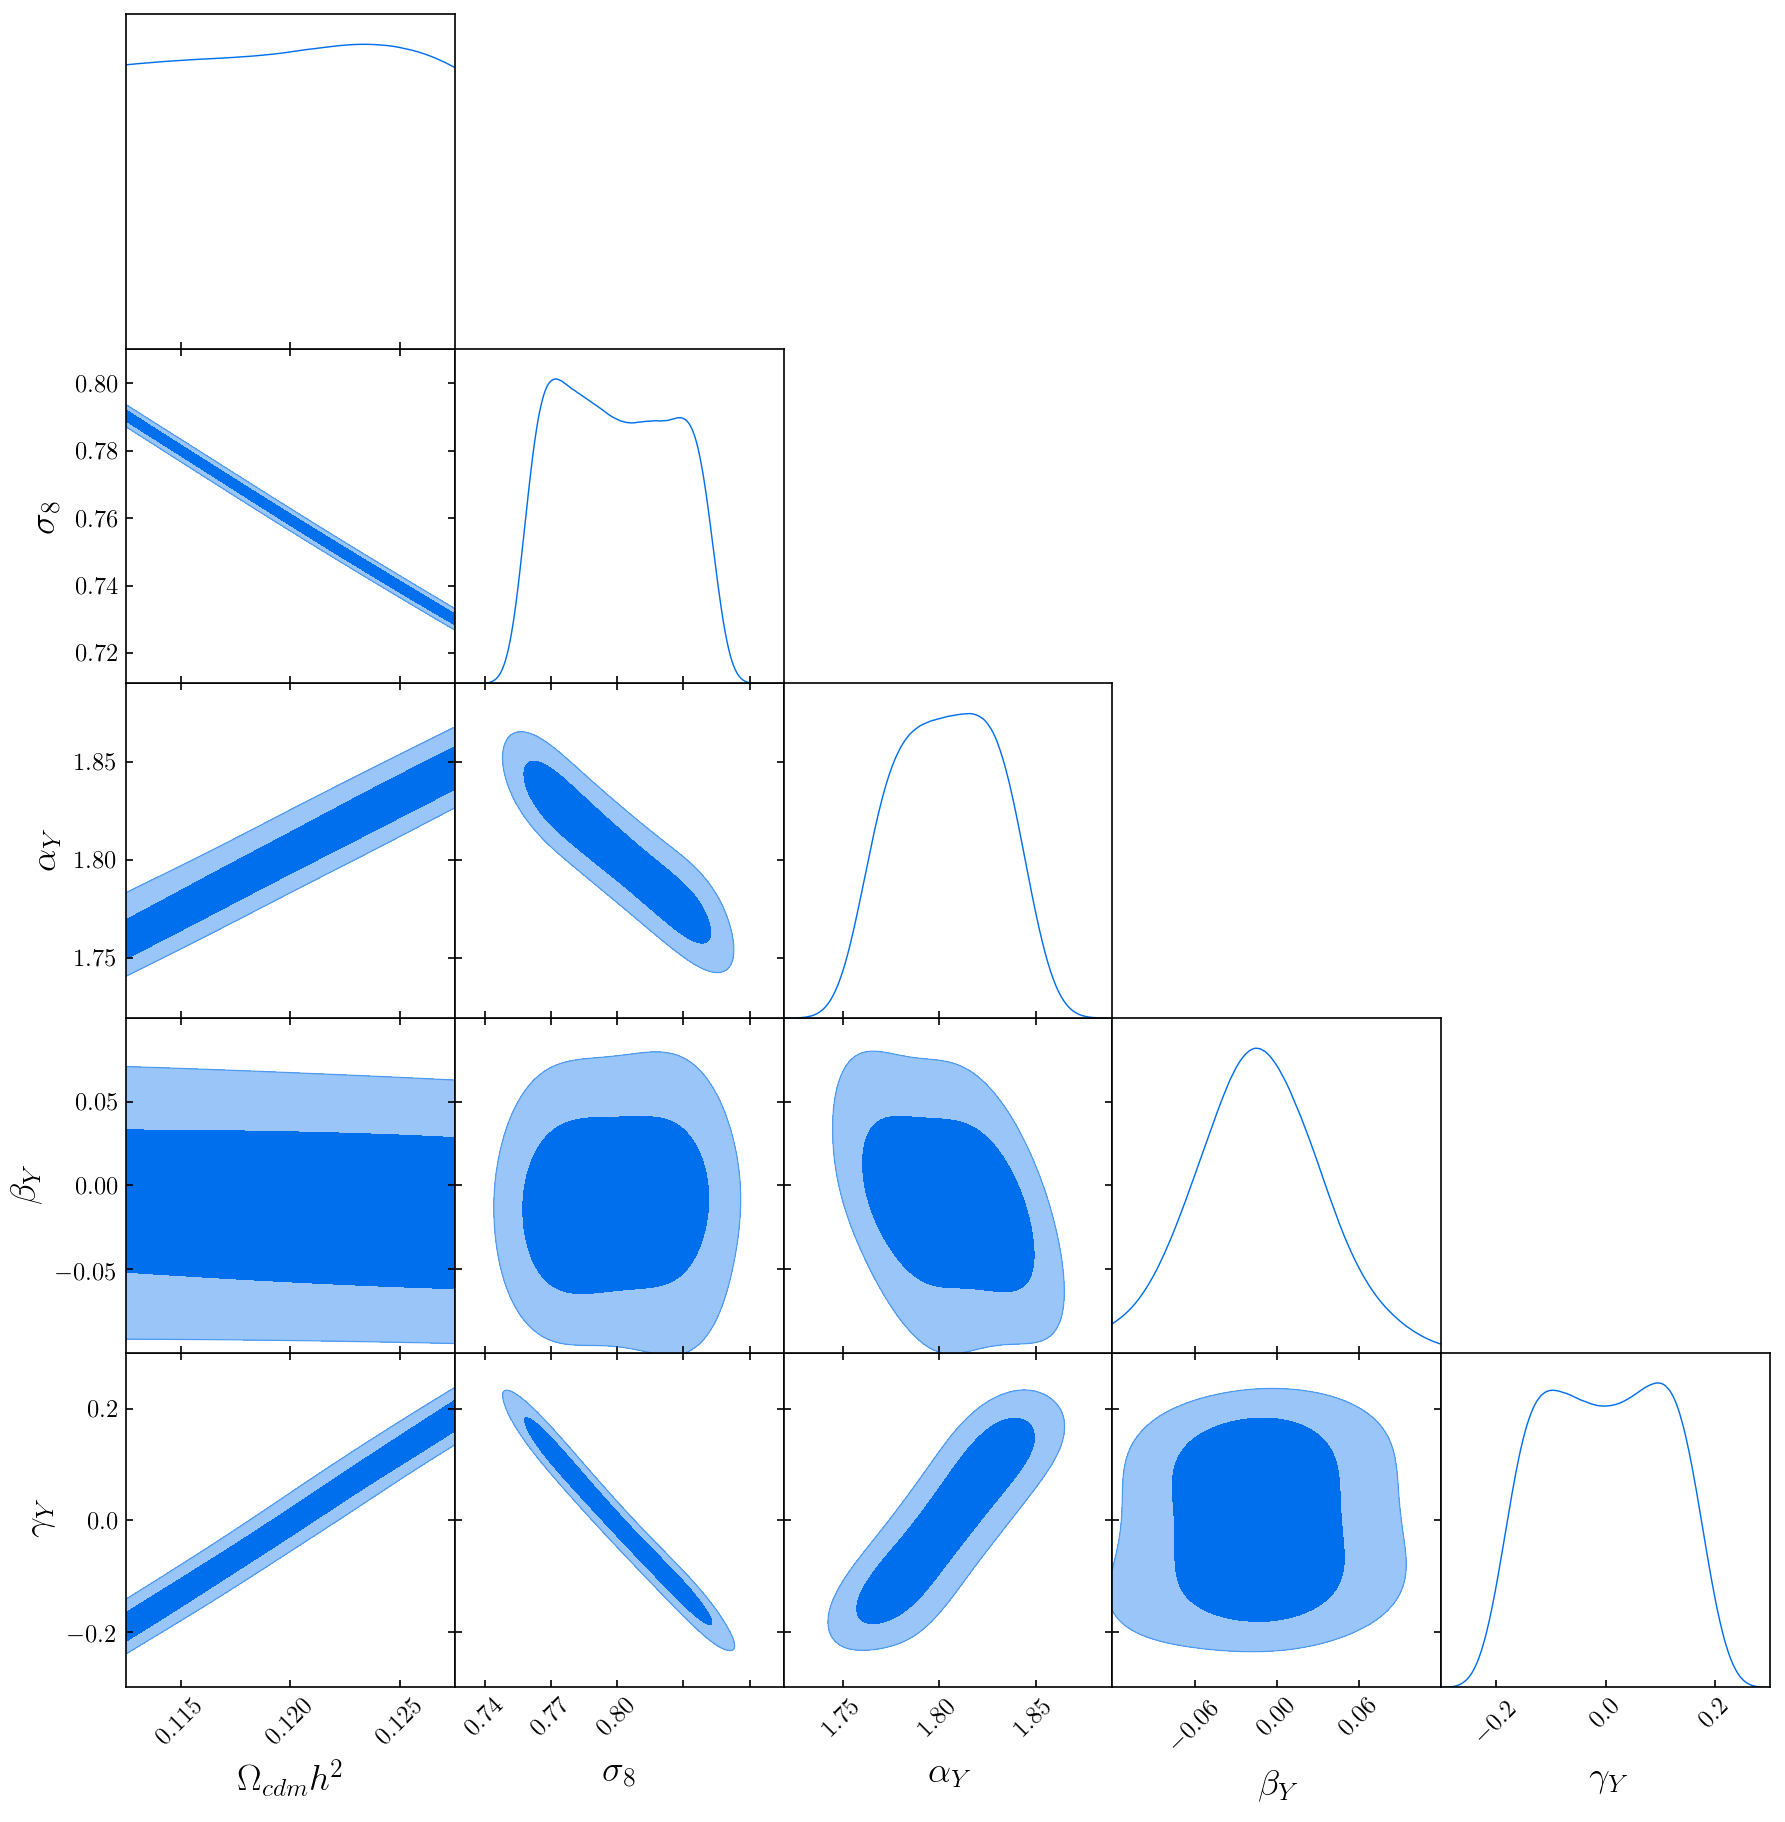

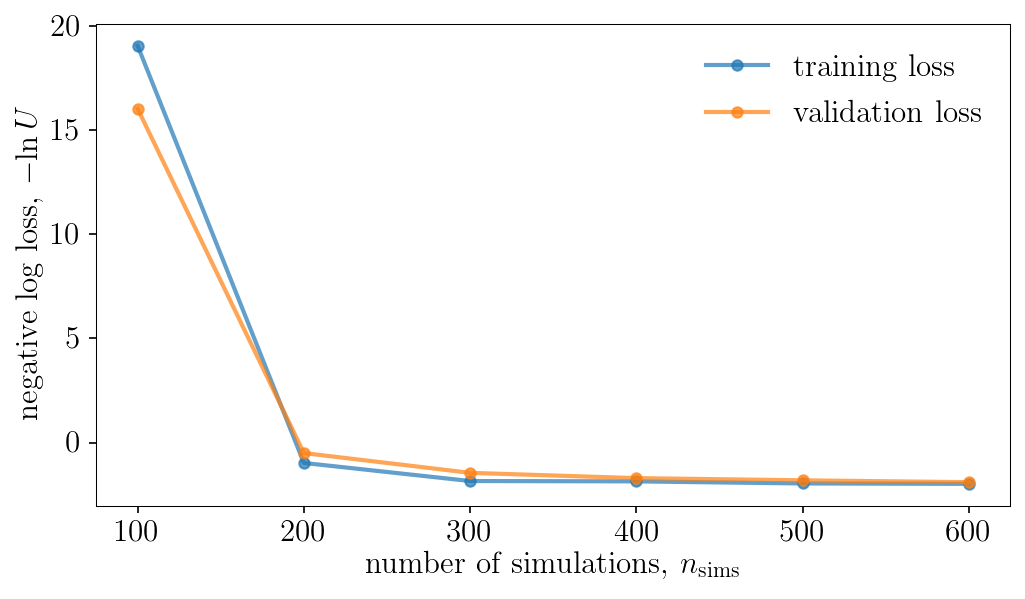

Population 6/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.084953689000031
simulation time: 4.016838093999468
simulation time: 4.005064809999567
simulation time: 4.109792228000515
simulation time: 3.998320980000244
simulation time: 4.000737767999453
simulation time: 3.9960468830004174
simulation time: 4.027600807999988
simulation time: 4.005345890999706
simulation time: 4.0224363810002615
simulation time: 4.020847196999966
simulation time: 4.024073317999864
simulation time: 4.011981562000074
simulation time: 4.0069311229999585
simulation time: 4.0206162619997485
simulation time: 3.9942200839996076
simulation time: 4.016990725999676
simulation time: 3.998058950000086
simulation time: 3.9946040450004148
simulation time: 4.0159846870001275
simulation time: 4.018216174999907
simulation time: 4.009236423999937
simulation time: 3.994053964000159
simulation time: 4.00012134499957
simulation time: 4.00440544400044
simulation time: 3.9941158940000605
simulation time: 3.9963794309996956
simulation time: 4.034066631000314
simulation ti

Sampling approximate posterior...


Done.
Removed no burn in


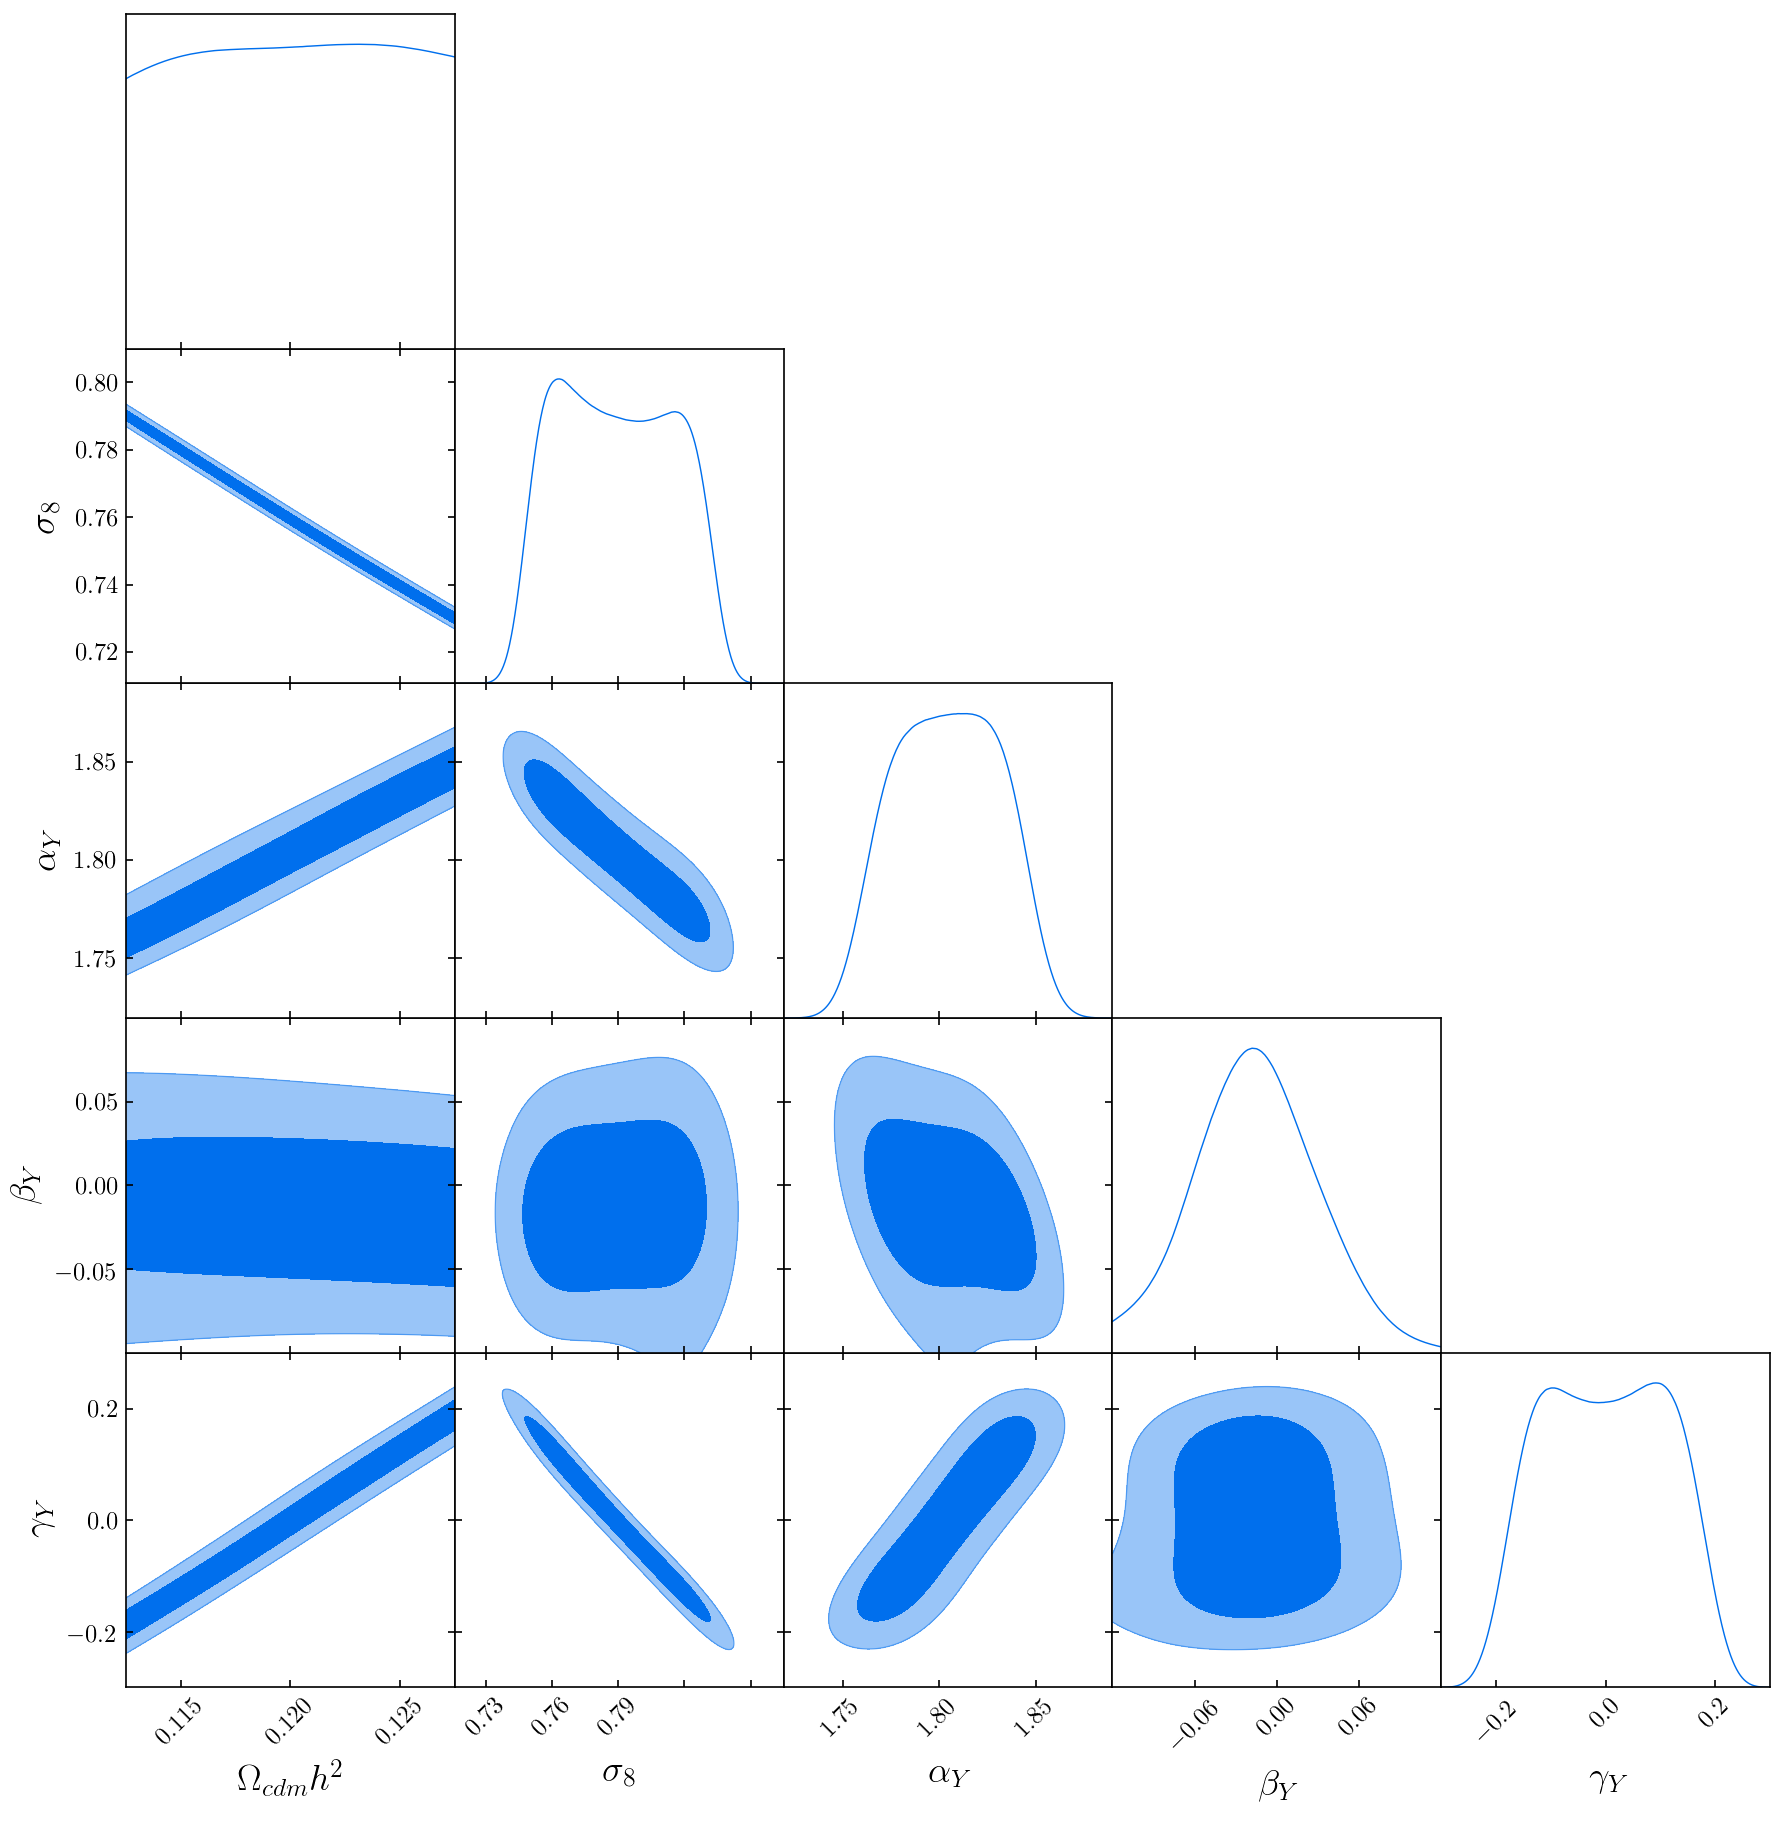

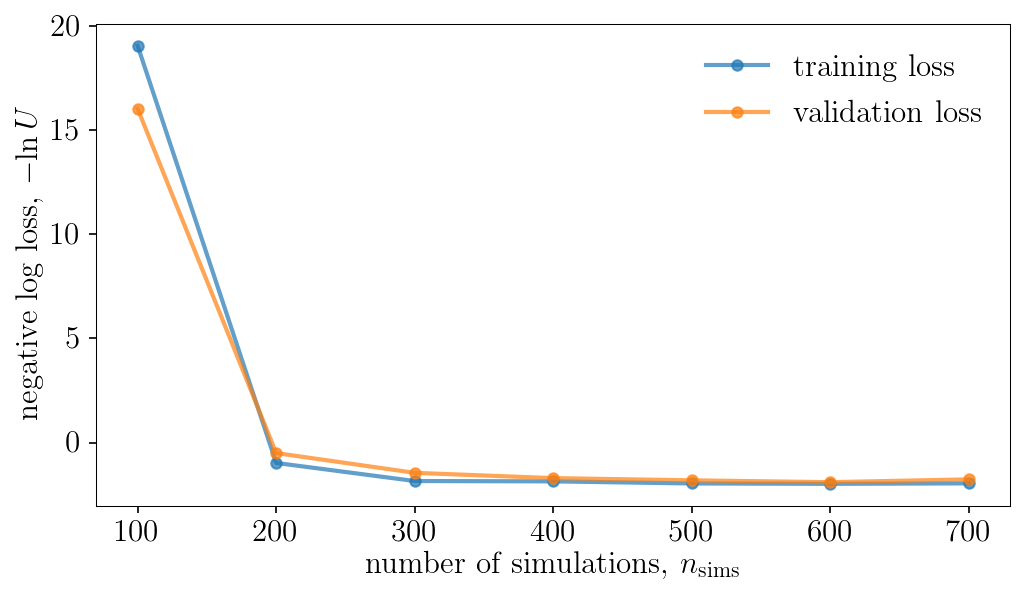

Population 7/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.125049920000492
simulation time: 4.003969697000684
simulation time: 4.008165304000613
simulation time: 4.0467188820002775
simulation time: 4.010405920000267
simulation time: 4.00810914900012
simulation time: 4.014948402999835
simulation time: 4.018372708000243
simulation time: 4.017226130999916
simulation time: 4.020505875000708
simulation time: 4.0329330429995025
simulation time: 4.005940565999481
simulation time: 4.009488663999946
simulation time: 4.015240471999277
simulation time: 4.00906942399979
simulation time: 4.008930186000725
simulation time: 4.041685449999932
simulation time: 4.016190983000342
simulation time: 4.04106001800028
simulation time: 4.007605388000229
simulation time: 4.0153004940002575
simulation time: 4.0130108889998155
simulation time: 4.034213691999867
simulation time: 4.032811127000059
simulation time: 4.016945794000094
simulation time: 4.0223984180001935
simulation time: 4.028374294000059
simulation time: 4.020198672000333
simulation time: 4

Sampling approximate posterior...
Done.
Removed no burn in


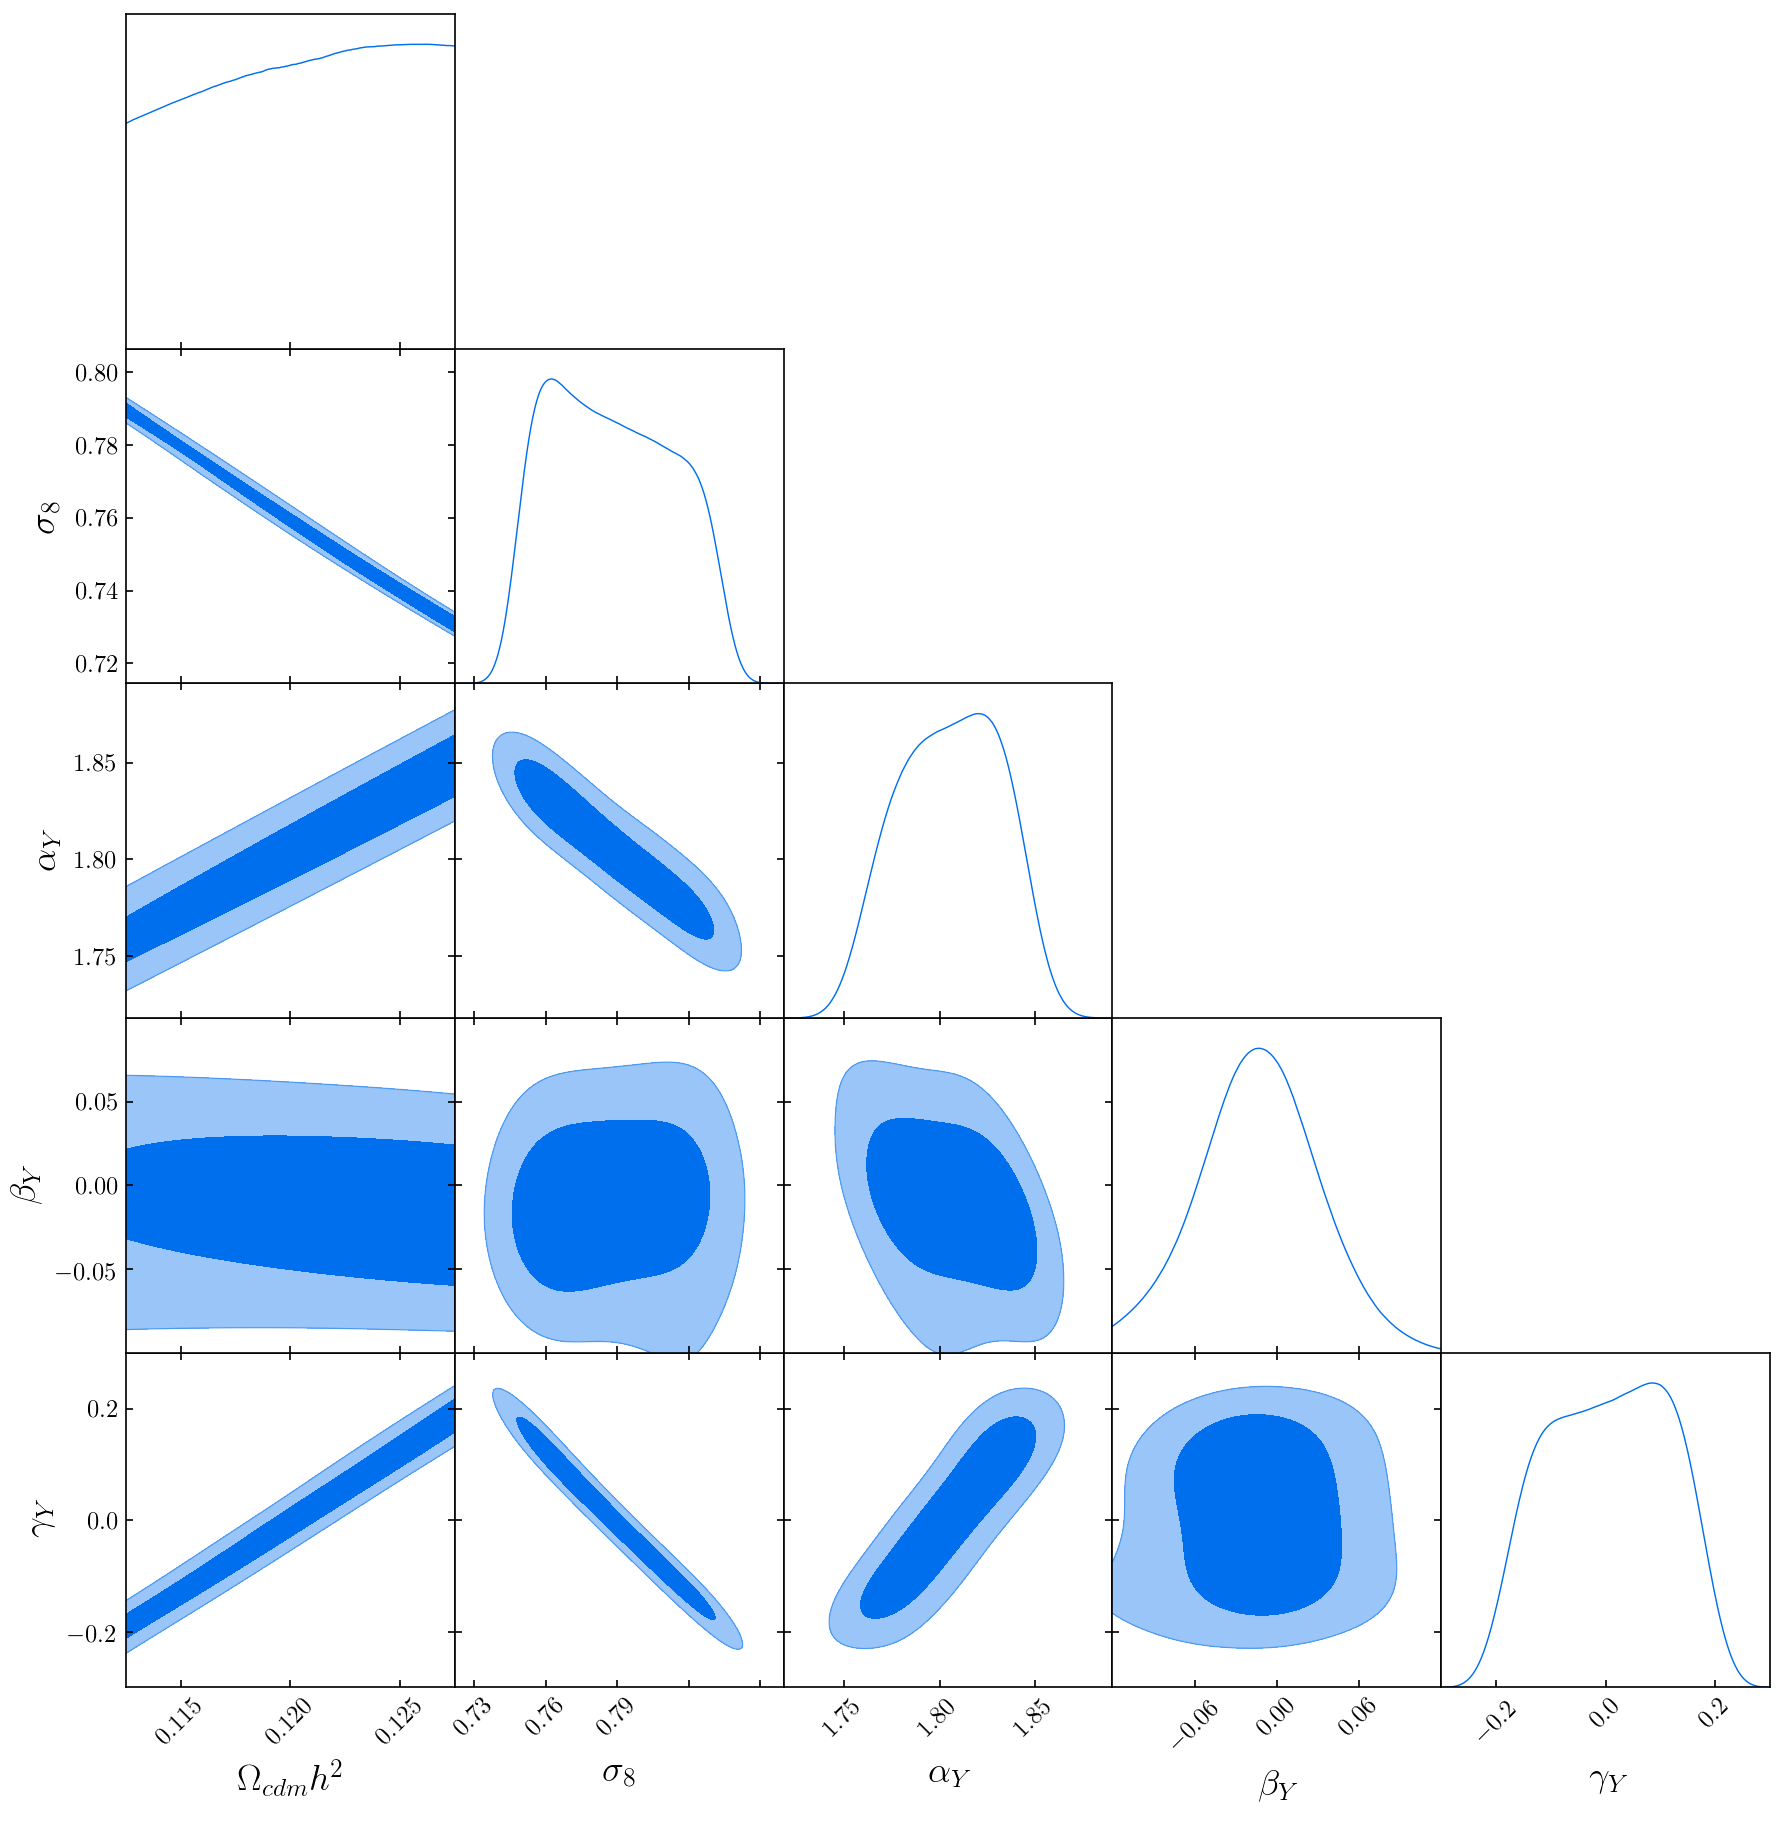

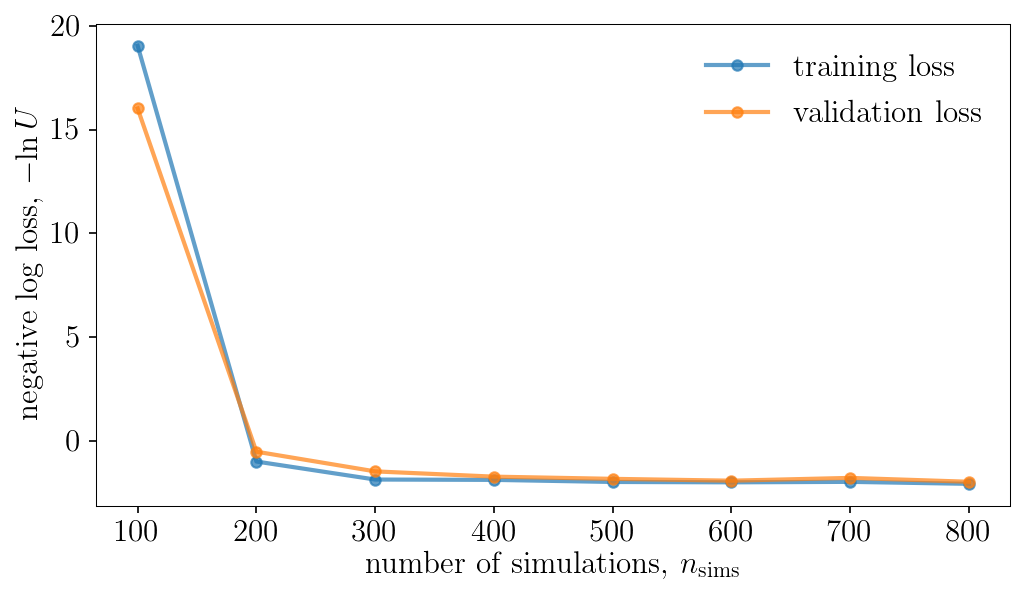

Population 8/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.02928515900021
simulation time: 4.004538477999631
simulation time: 4.040140920999875
simulation time: 4.014128679999885
simulation time: 4.008473555000819
simulation time: 4.012581725000018
simulation time: 4.017881022999973
simulation time: 4.016809200999887
simulation time: 4.087286620000668
simulation time: 4.013000064000153
simulation time: 4.0188201000000845
simulation time: 4.0057145440005115
simulation time: 4.0134129369998846
simulation time: 4.009764039000402
simulation time: 4.007913990999441
simulation time: 4.035561095000048
simulation time: 4.000131736000185
simulation time: 4.0108882989998165
simulation time: 4.0081348430003345
simulation time: 4.014738934999514
simulation time: 4.007617031000336
simulation time: 4.03298017599991
simulation time: 4.025617013000556
simulation time: 4.0105121540000255
simulation time: 4.009318263999376
simulation time: 4.010491263000404
simulation time: 4.014104851999946
simulation time: 4.019400289999794
simulation time:

Sampling approximate posterior...
Done.
Removed no burn in


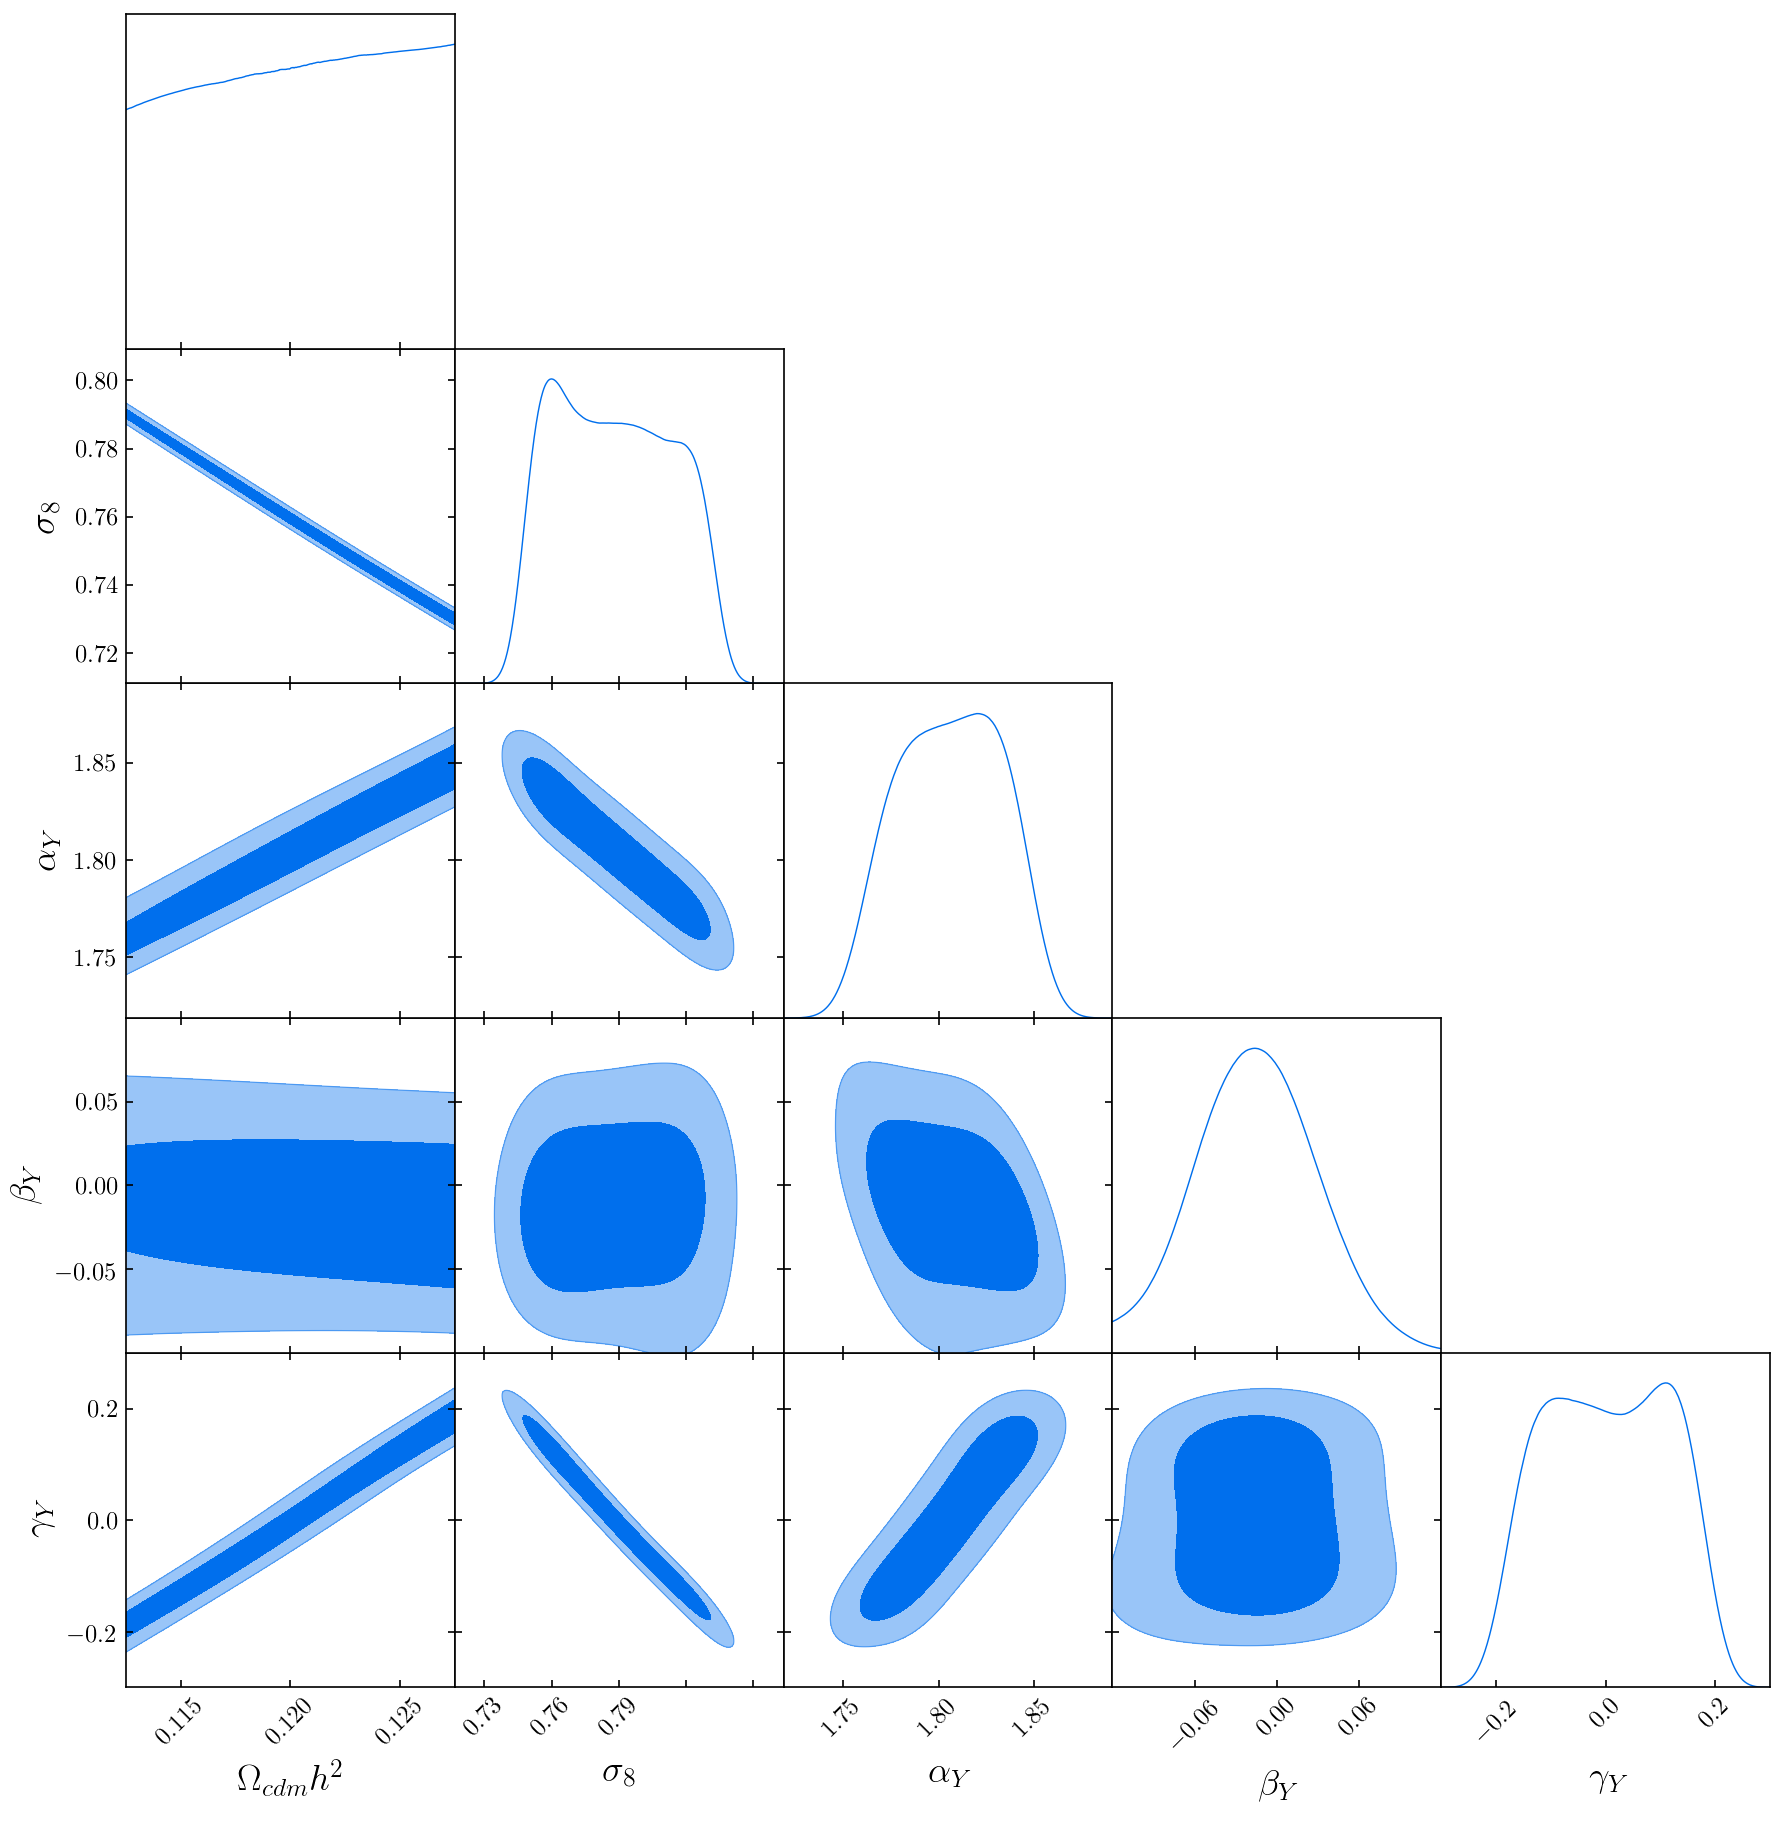

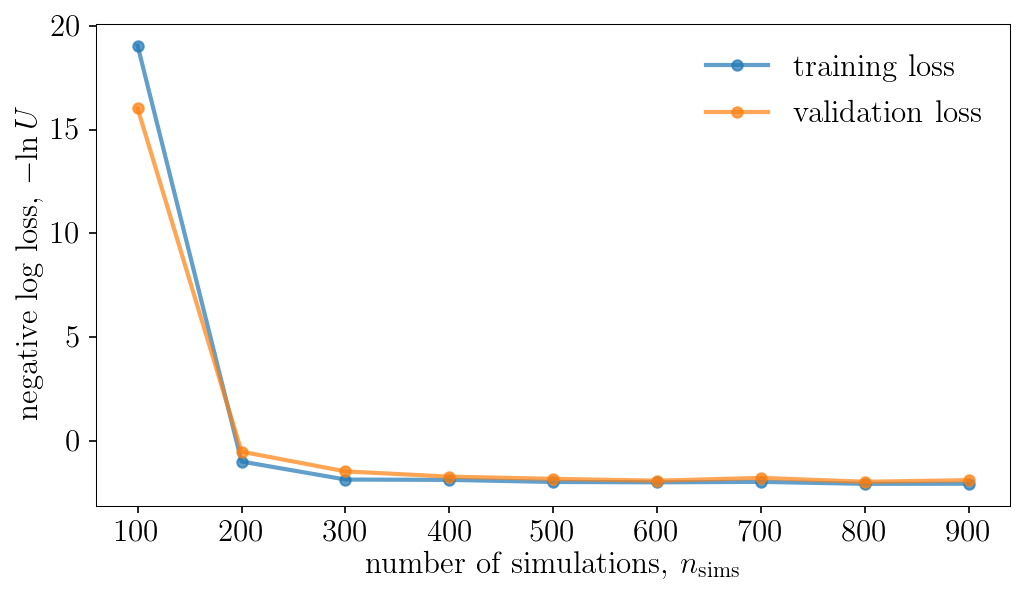

Population 9/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.1349190620003355
simulation time: 4.008540831999198
simulation time: 4.013157301000319
simulation time: 4.019080456999291
simulation time: 4.025546435001161
simulation time: 4.002363797000726
simulation time: 4.006103224999606
simulation time: 4.006377755000358
simulation time: 4.006067656000596
simulation time: 4.011392463999073
simulation time: 4.095614890999059
simulation time: 4.005239466998319
simulation time: 4.013556227000663
simulation time: 4.015188542000033
simulation time: 4.010321297999326
simulation time: 4.034969237998666
simulation time: 4.029744105999271
simulation time: 4.030863288999171
simulation time: 4.0113731540004665
simulation time: 4.015021788000013
simulation time: 4.024816281000312
simulation time: 4.0200996229996235
simulation time: 4.006721869000103
simulation time: 4.0309561750000285
simulation time: 4.009289196001191
simulation time: 4.011503601999721
simulation time: 4.009030409000843
simulation time: 4.012888322000435
simulation time:

Sampling approximate posterior...
Done.
Removed no burn in


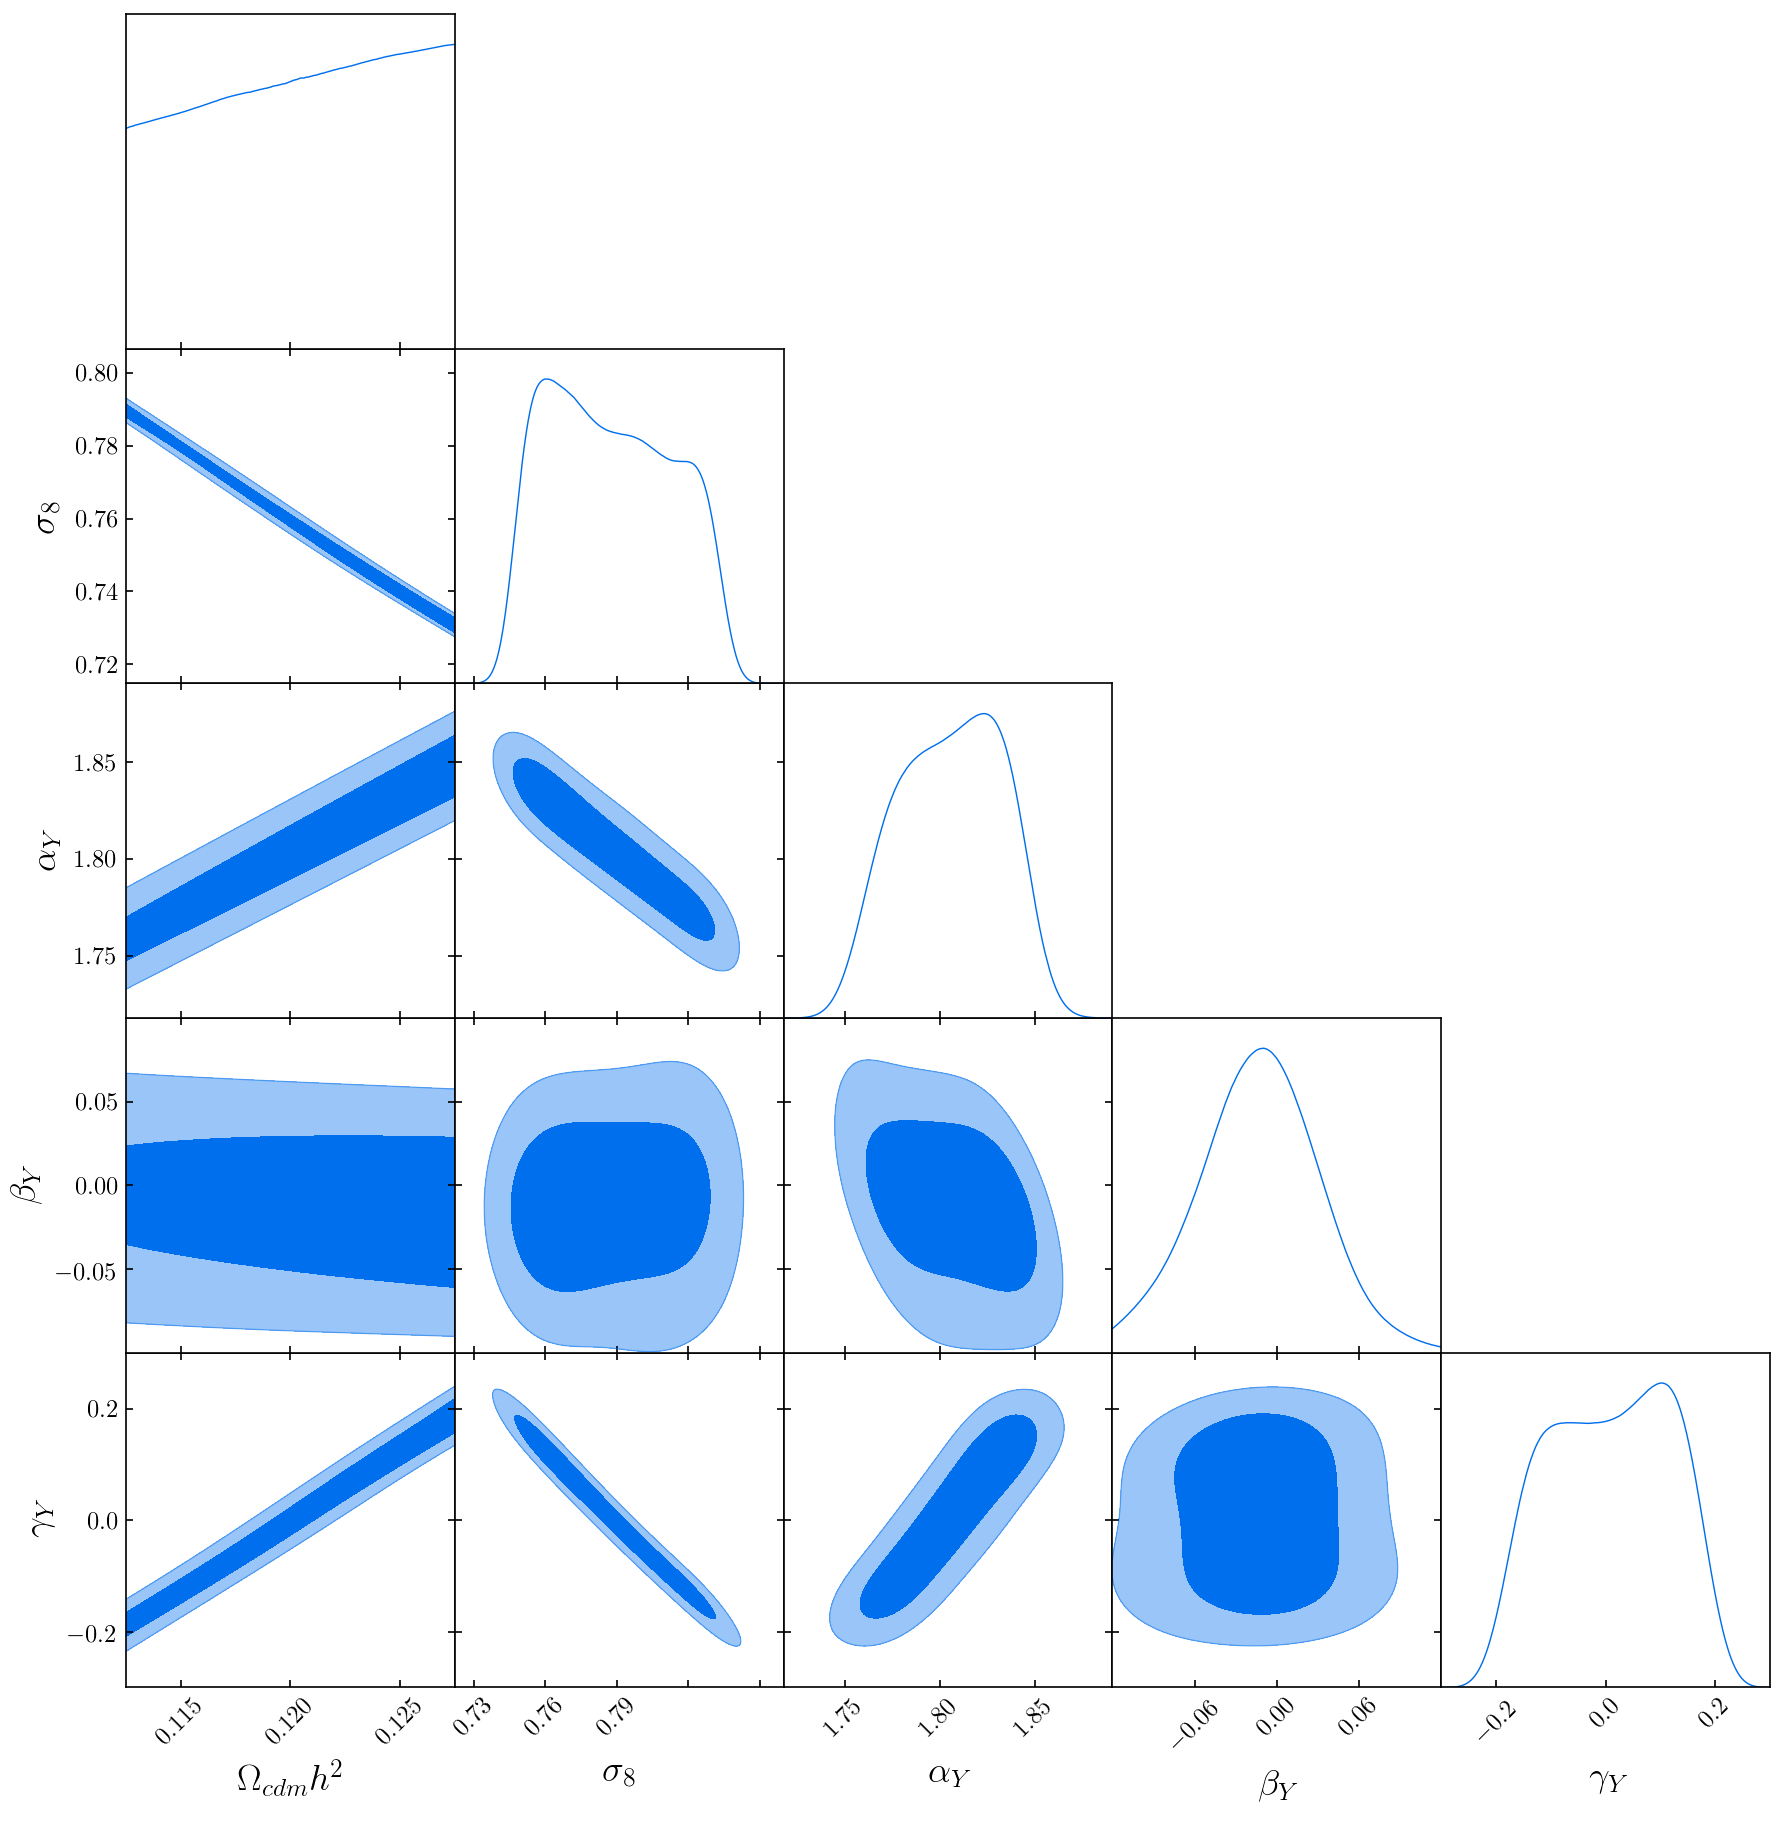

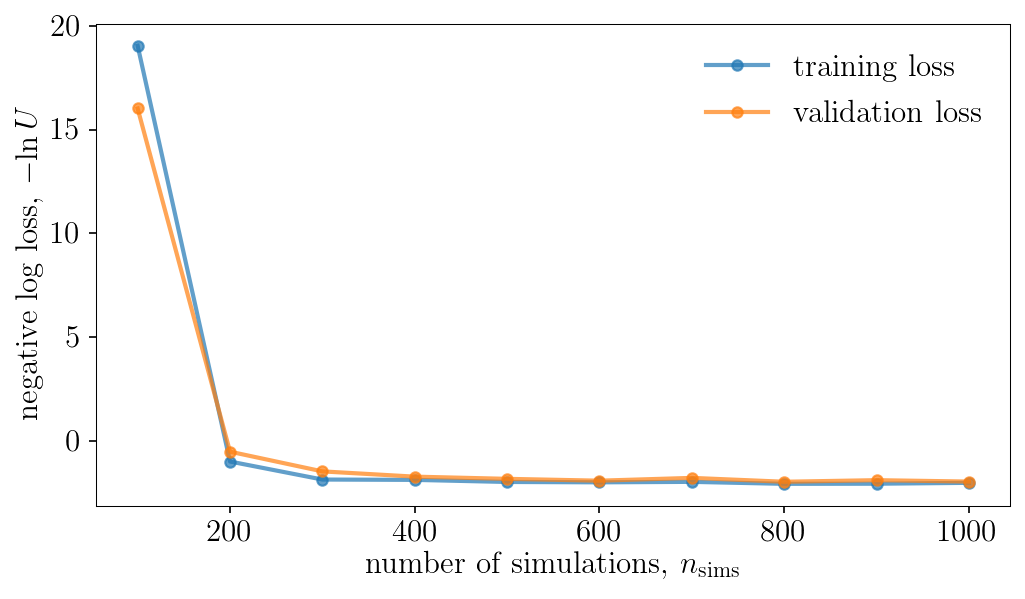

Population 10/10
Sampling proposal density...
Done.


/home/aizhana/pydelfi_cluster_counts/examples/simulators/mass_function_n_counts/simulator_trapz_m500_3.py:86: RuntimeWarning: divide by zero encountered in power
  D_A_z = (ccl.background.comoving_radial_distance(cosmo_ccl, scale_fact_a)/100)**(-2)


simulation time: 4.1101967680006055
simulation time: 4.029235813000923
simulation time: 4.019784807000178
simulation time: 4.048225227999865
simulation time: 4.018603753000207
simulation time: 4.02447467499951
simulation time: 4.022794522999902
simulation time: 4.022878161000335
simulation time: 4.027633921001325
simulation time: 4.096347059999971
simulation time: 4.05257906100087
simulation time: 4.016214997000134
simulation time: 4.024577562000559
simulation time: 4.027953193999565
simulation time: 4.018289793999429
simulation time: 4.015685147998738
simulation time: 4.051032457000474
simulation time: 4.090869564999593
simulation time: 4.091424103000463
simulation time: 4.0724211699998705
simulation time: 4.090440961999775
simulation time: 4.0221325529983005
simulation time: 4.082059702001061
simulation time: 4.041890153001077
simulation time: 4.057524148998709
simulation time: 4.08187710600032
simulation time: 4.080345727999884
simulation time: 4.059177920998991
simulation time: 4.0

Sampling approximate posterior...
Done.
Removed no burn in


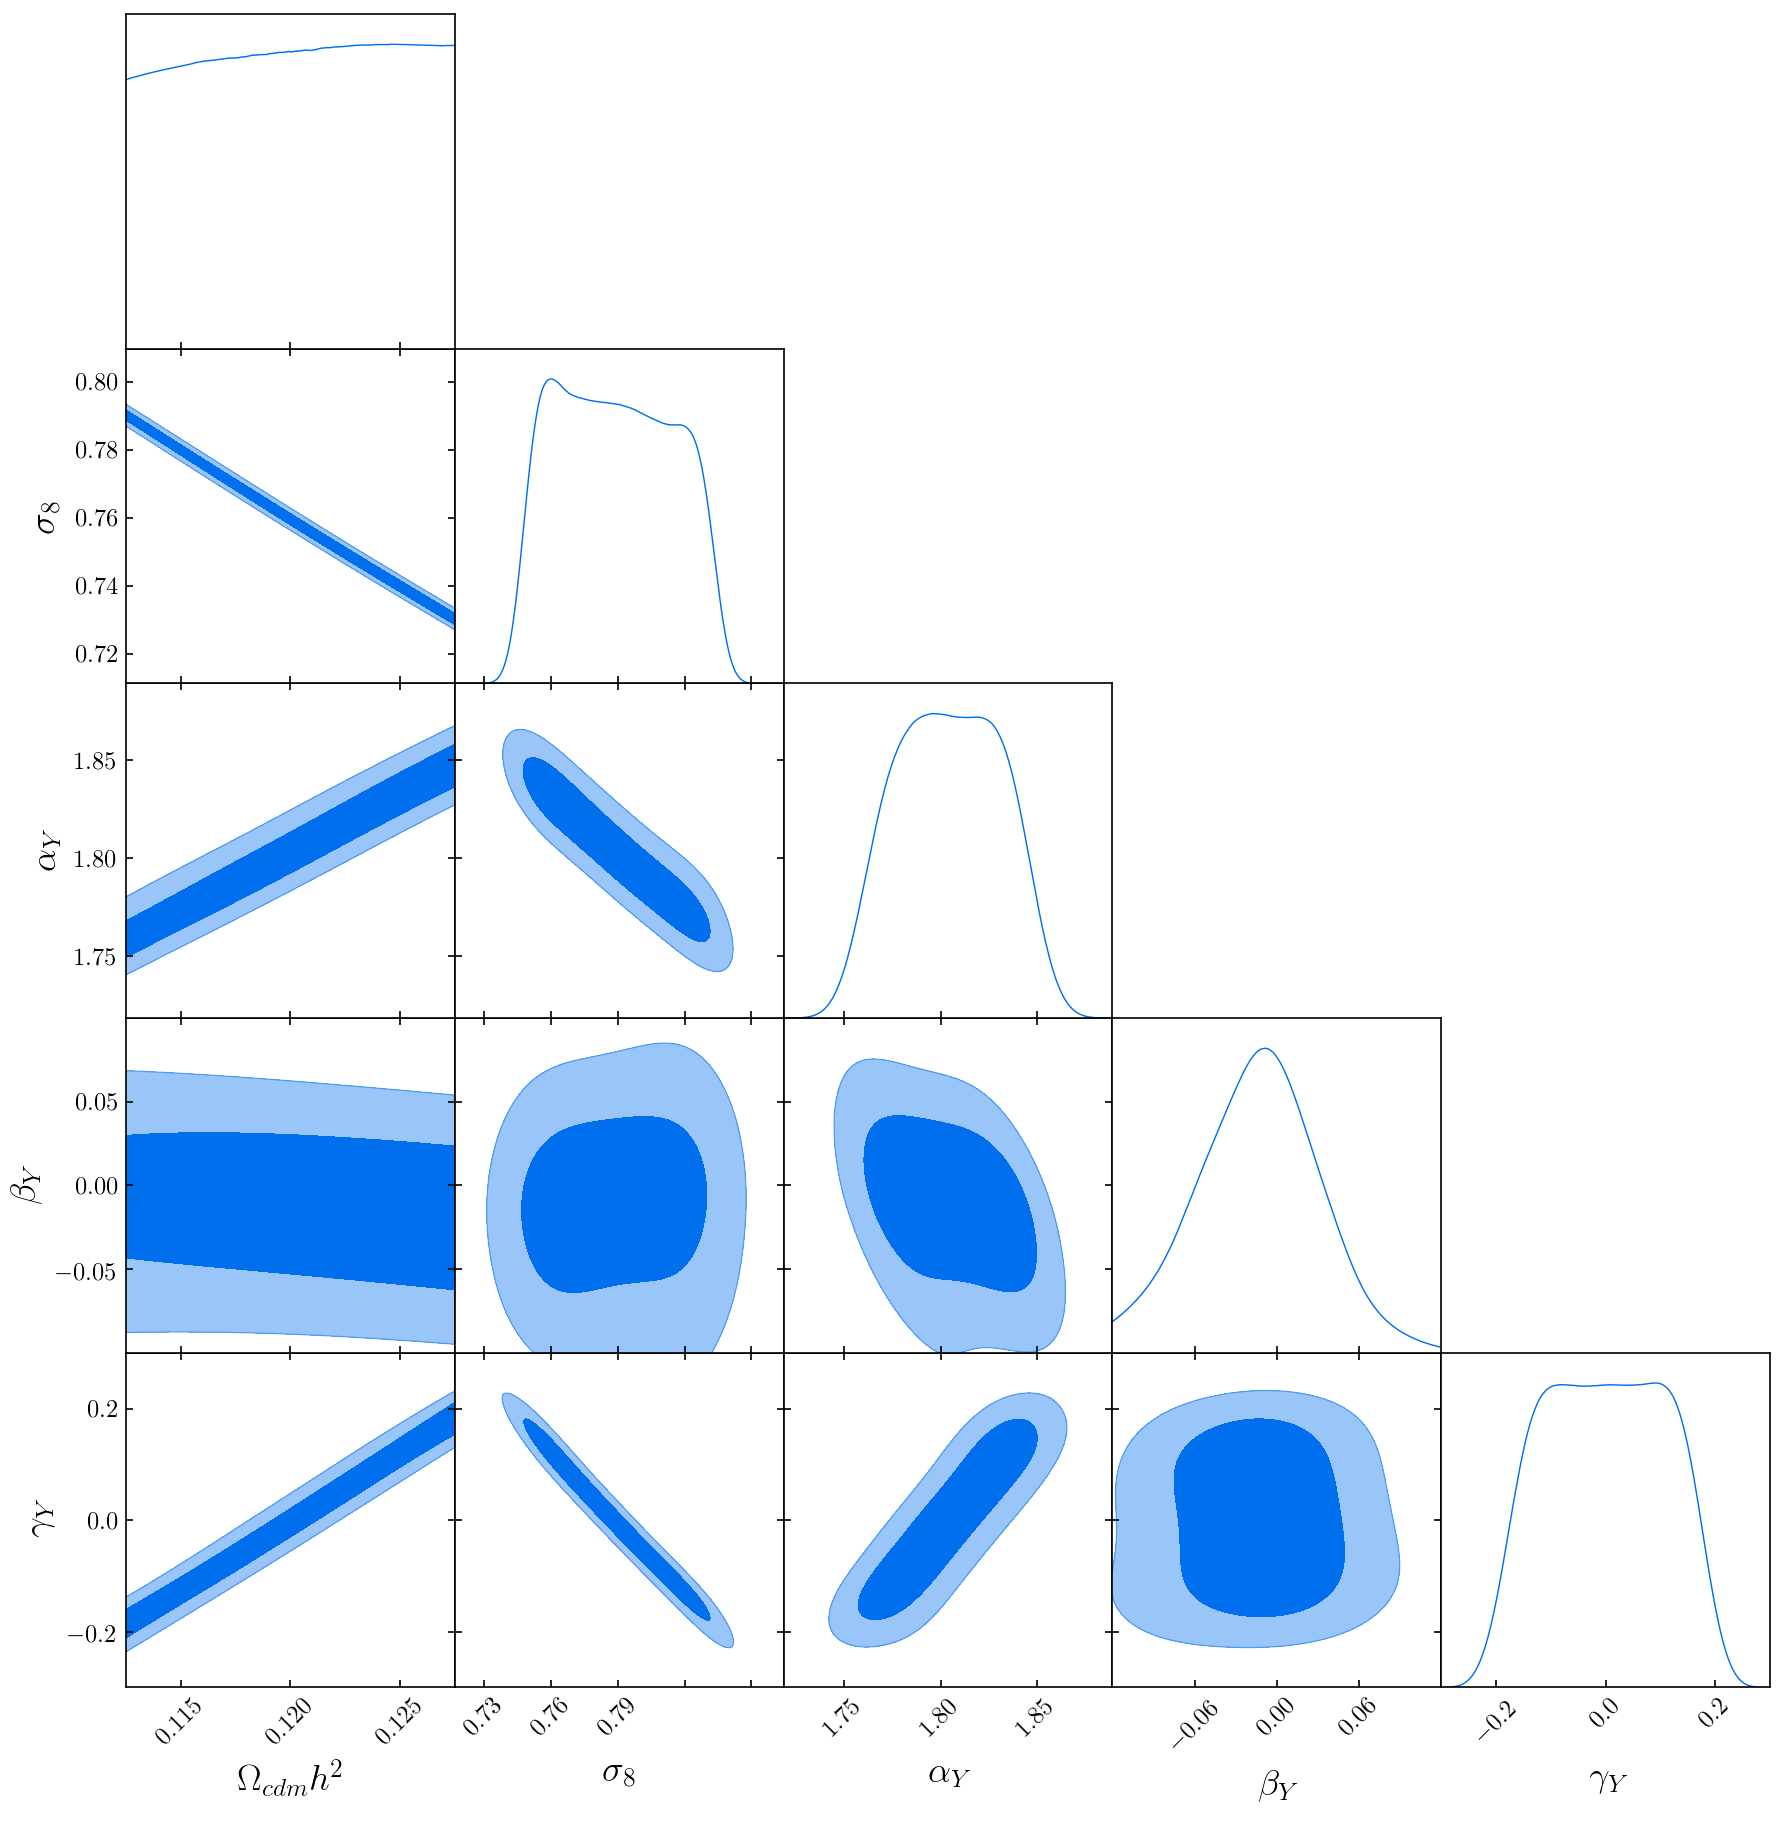

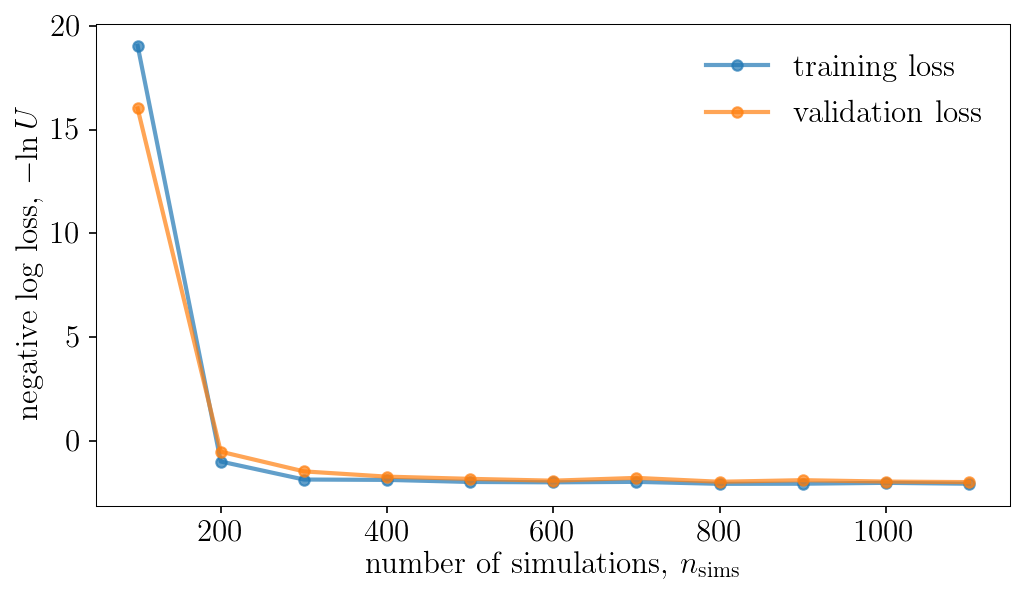

In [38]:
DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations, patience=20, 
                                  save_intermediate_posteriors=True)